In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold

## directory where results are
CHANSEY_ROOT = "W:"
EXPERIMENT_DIR = f"{CHANSEY_ROOT}/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
RESULTS_DIR = f"{TEAMS_DIR}/fairness-analysis-results"
FIG_DIR = f"{TEAMS_DIR}/figs"
TAB_DIR = f"{TEAMS_DIR}/tables"

In [2]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 131 entries, PatientID to SliceCount
dtypes: bool(27), float64(86), int64(12), object(6)
memory usage: 13.2+ MB


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'nodule': ['CoordX', 'CoordZ', 'CoordY', 'Mean_Entropy_Kiran'],
  'other': ['NoduleCounts', 'Diameter_mm', 'SliceCount']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'ca

# Materials

## Demographic characteristics of the NLST validation sets (n=5911 scans, n=1172 scans).

In [4]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_1172, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911), len(nlst_1172)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


(5911, 1172)

In [5]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

nlstval_some_mal = nlst_1172.query('label == 1')
nlstval_some_ben = nlst_1172.query('label == 0')
print('some:', len(nlstval_some_ben), 'ben', len(nlstval_some_mal), 'mal')

full: 5330 ben 581 mal
some: 1045 ben 127 mal


In [6]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    # "Full (all)": nlst_5911,
    "Partial (malignant)": nlstval_some_mal,
    "Partial (benign)": nlstval_some_ben,
    # "Partial (all)": nlst_1172,
}

In [7]:
df = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
df
# df[(df['category'] == "demo") & (df['attribute'].isin(['Gender', 'race', 'educat', 'Married', 'marital', 'ethnic']))]

,category,attribute,value,Full (malignant)_freq,Full (malignant)_norm,Full (benign)_freq,Full (benign)_norm,Partial (malignant)_freq,Partial (malignant)_norm,Partial (benign)_freq,Partial (benign)_norm,diff_Full (malignant)_Full (benign),diff_Full (malignant)_Partial (malignant),diff_Full (malignant)_Partial (benign),diff_Full (benign)_Partial (malignant),diff_Full (benign)_Partial (benign),diff_Partial (malignant)_Partial (benign)
0,Demographics,BMI Class,25 or Above,372.0,64.0275,3640.0,68.2927,82.0,64.5669,719.0,68.8038,-4.2652,-0.5394,-4.7763,3.7258,-0.5111,-4.2369
1,Demographics,BMI Class,Below 25,209.0,35.9725,1690.0,31.7073,45.0,35.4331,326.0,31.1962,4.2652,0.5394,4.7763,-3.7258,0.5111,4.2369
2,Demographics,Education Status,8th grade or less,9.0,1.5491,102.0,1.9137,4.0,3.1496,23.0,2.2010,-0.3646,-1.6005,-0.6519,-1.2359,-0.2873,0.9486
3,Demographics,Education Status,9th-11th grade,32.0,5.5077,258.0,4.8405,2.0,1.5748,65.0,6.2201,0.6672,3.9329,-0.7124,3.2657,-1.3796,-4.6453
4,Demographics,Education Status,Associate Degree,126.0,21.6867,1175.0,22.0450,31.0,24.4094,213.0,20.3828,-0.3583,-2.7227,1.3039,-2.3644,1.6622,4.0266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Scanner,Model Name,QX/i,1.0,0.1721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,Scanner,Model Name,Sensation 16,96.0,16.5232,719.0,13.4897,19.0,14.9606,138.0,13.2057,3.0335,1.5626,3.3175,-1.4709,0.2840,1.7549
258,Scanner,Model Name,Sensation 4,7.0,1.2048,169.0,3.1707,NaN,NaN,31.0,2.9665,-1.9659,NaN,-1.7617,NaN,0.2042,NaN
259,Scanner,Model Name,Sensation 64,9.0,1.5491,56.0,1.0507,2.0,1.5748,10.0,0.9569,0.4984,-0.0257,0.5922,-0.5241,0.0938,0.6179


In [8]:
for s in validation_sets:
    df[f"{s}_info"] = df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

df_out = df[
    (df['category'] == "Demographics") 
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
df_out

,attribute,value,Full (malignant)_info,Full (benign)_info,Partial (malignant)_info,Partial (benign)_info
0,BMI Class,25 or Above,372 (64.0),3640 (68.3),82 (64.6),719 (68.8)
1,BMI Class,Below 25,209 (36.0),1690 (31.7),45 (35.4),326 (31.2)
2,Education Status,8th grade or less,9 (1.5),102 (1.9),4 (3.1),23 (2.2)
3,Education Status,9th-11th grade,32 (5.5),258 (4.8),2 (1.6),65 (6.2)
4,Education Status,Associate Degree,126 (21.7),1175 (22.0),31 (24.4),213 (20.4)
5,Education Status,Bachelors Degree,96 (16.5),817 (15.3),21 (16.5),164 (15.7)
6,Education Status,Graduate School,76 (13.1),778 (14.6),16 (12.6),163 (15.6)
7,Education Status,HS Graduate / GED,141 (24.3),1338 (25.1),36 (28.3),271 (25.9)
8,Education Status,Post-HS training,87 (15.0),765 (14.4),16 (12.6),128 (12.2)
10,Gender,Female,244 (42.0),2226 (41.8),48 (37.8),431 (41.2)


In [9]:
df_out_idx = pd.MultiIndex.from_frame(df_out[['attribute', 'value']])
df_out2 = df_out.set_index(df_out_idx)[[f"{s}_info" for s in validation_sets]]

multicol_idx = pd.MultiIndex.from_tuples([
    ('Full Dataset (n=5911 Scans)', 'Malignant (n=581)'),
    ('Full Dataset (n=5911 Scans)', 'Benign (n=5330)'),
    # ('Full Dataset (n=5911 Scans)', 'Total'),
    ('Partial Dataset (n=1172 Scans)', 'Malignant (n=127)'),
    ('Partial Dataset (n=1172 Scans)', 'Benign (n=1045)'),
    # ('Partial Dataset (n=1172 Scans)', 'Total'),
])

df_out2.columns = multicol_idx
df_out2

Full Dataset (n=5911 Scans)  \
                                                         Malignant (n=581)   
attribute                  value                                             
BMI Class                  25 or Above                          372 (64.0)   
                           Below 25                             209 (36.0)   
Education Status           8th grade or less                       9 (1.5)   
                           9th-11th grade                         32 (5.5)   
                           Associate Degree                     126 (21.7)   
                           Bachelors Degree                      96 (16.5)   
                           Graduate School                       76 (13.1)   
                           HS Graduate / GED                    141 (24.3)   
                           Post-HS training                      87 (15.0)   
Gender                     Female                               244 (42.0)   
                           Male                                 337 (58.0)   
Married                    False                                197 (33.9)   
                           True                                 384 (66.1)   
HS Education               False                                   9 (1.5)   
                           True                                 572 (98.5)   
Non-Hispanic White         False                                  55 (9.5)   
                           True                                 526 (90.5)   
Unfinished Education Level False                                423 (72.8)   
                           True                                 158 (27.2)   
White or Black             Black                                  28 (4.8)   
                           White                                530 (91.2)   
Marital Status             Divorced                             125 (21.5)   
                           Married                              384 (66.1)   
                           Never Married                          16 (2.8)   
                           Separated                               5 (0.9)   
                           Widowed                                49 (8.4)   
Ethnicity                  Hispanic/Latino                         4 (0.7)   
                           Not Hispanic/Latino                  574 (98.8)   
Race                       Asian                                   6 (1.0)   
                           Black                                  28 (4.8)   
                           More than one race                      6 (1.0)   
                           Native American                         8 (1.4)   
                           Native Hawaiian                         1 (0.2)   
                           White                                530 (91.2)   

                                                                \
                                               Benign (n=5330)   
attribute                  value                                 
BMI Class                  25 or Above             3640 (68.3)   
                           Below 25                1690 (31.7)   
Education Status           8th grade or less         102 (1.9)   
                           9th-11th grade            258 (4.8)   
                           Associate Degree        1175 (22.0)   
                           Bachelors Degree         817 (15.3)   
                           Graduate School          778 (14.6)   
                           HS Graduate / GED       1338 (25.1)   
                           Post-HS training         765 (14.4)   
Gender                     Female                  2226 (41.8)   
                           Male                    3104 (58.2)   
Married                    False                   1740 (32.6)   
                           True                    3590 (67.4)   
HS Education               False                     102 (1.9)   
                           True       

In [10]:
print(df_out2.style.to_latex(buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans).'))

None


In [51]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[
    (num_df['category'] == "Demographics") & (num_df['value'].isin(['Mean (SD)', 'Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['attribute', 'value']]))[[f"{s}" for s in validation_sets]]
num_df.columns = multicol_idx
num_df

Full Dataset (n=5911 Scans)                  \
                                 Malignant (n=581) Benign (n=5330)   
attribute value                                                      
BMI       Mean (SD)                     26.8 (4.4)      27.6 (5.0)   
          Median (IQR)                      26 (4)          27 (6)   
Age       Mean (SD)                     64.1 (5.2)      63.1 (5.3)   
          Median (IQR)                      64 (8)          62 (8)   
Height    Mean (SD)                     67.9 (3.9)      68.0 (4.0)   
          Median (IQR)                      68 (6)          68 (6)   
Weight    Mean (SD)                   176.5 (36.8)    182.5 (39.5)   
          Median (IQR)                    175 (50)        180 (50)   

                       Partial Dataset (n=1172 Scans)                  
                                    Malignant (n=127) Benign (n=1045)  
attribute value                                                        
BMI       Mean (SD)                        26.7 (4.6)      27.7 (4.9)  
          Median (IQR)                         25 (5)          27 (6)  
Age       Mean (SD)                        64.1 (5.2)      63.2 (5.4)  
          Median (IQR)                         63 (7)          62 (8)  
Height    Mean (SD)                        68.4 (3.7)      68.1 (3.9)  
          Median (IQR)                         69 (5)          68 (6)  
Weight    Mean (SD)                      178.2 (36.4)    183.4 (39.8)  
          Median (IQR)                       180 (43)        180 (49)

In [52]:
df_out2 = pd.concat([df_out2, num_df], axis=0)

In [53]:
print(df_out2.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation sets (n={len(nlst_5911)} scans, n={len(nlst_1172)} scans). HS = High School.'))

None


## DLCST vs. NLST

In [54]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=True)

dlcst_democols = {
    'cat': {'demo': ['Sex'], 'other': ['FamilyHistoryLungCa', 'Emphysema']},
    'num': {'demo': ['Age'], 'other': ['NoduleCountPerScan']}
}
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)
display(dlcst_valset)
dlcst_cols

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


,PatientID,StudyDate,SeriesInstanceUID,Age,Gender,Family History of LC,Emphysema in Scan,Nodules Per Scan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label,Ensemble_Kiran_cal,thijmen_mean_cal
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,Female,False,False,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0,0.119066,0.097887
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,Male,True,True,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0,0.018347,0.006485
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,Female,False,True,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0,0.035409,0.048255
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,Male,False,True,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0,0.119856,0.226322
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,Male,False,True,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0,0.005651,0.008965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4057,20060314,1.2.840.113704.1.111.4796.1142355218.14,69,Male,False,True,2,0.168810,0.273494,0.257961,0.294720,0.327062,0.383196,0.380198,0.893933,0.682322,0,0.439657,0.400826
595,4063,20060313,1.2.840.113704.1.111.5104.1142267340.10,55,Male,False,True,4,0.001965,0.006793,0.013618,0.017289,0.021685,0.035951,0.000000,0.000099,0.103020,0,0.011303,0.067322
596,4079,20060328,1.2.840.113704.1.111.1308.1143556124.11,52,Female,False,False,1,0.003951,0.011459,0.025373,0.034010,0.040101,0.058852,0.039054,0.070744,0.121373,0,0.112500,0.076349
597,4098,20060403,1.2.840.113704.1.111.5848.1144079789.11,54,Male,False,True,3,0.117795,0.167839,0.189976,0.217799,0.229753,0.300137,0.134158,0.452513,0.347016,0,0.241085,0.185779


{'cat': {'Demographics': ['Gender'],
  'Other': ['Family History of LC', 'Emphysema in Scan']},
 'num': {'Demographics': ['Age'], 'Other': ['Nodules Per Scan']}}

In [55]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx
df_popshift

NLST Validation (n=5911 Scans)                  \
                                         Malignant (n=581) Benign (n=5330)   
attribute            value                                                   
Gender               Female                     244 (42.0)     2226 (41.8)   
                     Male                       337 (58.0)     3104 (58.2)   
Family History of LC False                      401 (69.0)     3983 (74.7)   
                     True                       180 (31.0)     1347 (25.3)   
Emphysema in Scan    False                      317 (54.6)     3438 (64.5)   
                     True                       264 (45.4)     1892 (35.5)   

                            DLCST Validation (n=599 Scans)                 
                                          Malignant (n=59) Benign (n=540)  
attribute            value                                                 
Gender               Female                      27 (45.8)     249 (46.1)  
                     Male                        32 (54.2)     291 (53.9)  
Family History of LC False                       43 (72.9)     454 (84.1)  
                     True                        16 (27.1)      86 (15.9)  
Emphysema in Scan    False                       15 (25.4)     179 (33.1)  
                     True                        44 (74.6)     361 (66.9)

In [56]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Mean (SD)', 'Median (IQR)']))
    # & (df['attribute'].isin(['Gender', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx
num_popshift

NLST Validation (n=5911 Scans)                  \
                                    Malignant (n=581) Benign (n=5330)   
attribute value                                                         
Age       Mean (SD)                        64.1 (5.2)      63.1 (5.3)   
          Median (IQR)                         64 (8)          62 (8)   

                       DLCST Validation (n=599 Scans)                 
                                     Malignant (n=59) Benign (n=540)  
attribute value                                                       
Age       Mean (SD)                        62.0 (4.9)     58.0 (4.8)  
          Median (IQR)                         62 (7)         58 (7)

In [57]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)

In [58]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [59]:
policies = (
    ("Sensitivity", 0.9),
    # ("Sensitivity", 1.0),
    ("Specificity", 0.9),
    # ("Specificity", 1.0),
    # ("Youden J", 1.0),  ## Max J statistic
)

In [60]:
DLCST_MODELCOLS = {
    "Venkadesh": "Ensemble_Kiran_cal",
    "De Haas Combined": "thijmen_mean_cal",
    "PanCan2b": "PanCan2b",
    "Sybil (Year 1)": "sybil_year1",
}
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=DLCST_MODELCOLS, policies=policies, brock=True)
dlcst_policies

,Sensitivity=0.9,Specificity=0.9,Brock
Venkadesh,0.134,0.204,0.06
De Haas Combined,0.099,0.193,0.06
PanCan2b,0.020,0.093,0.06
Sybil (Year 1),0.001,0.018,0.06


In [61]:
NLST_1172_MODELCOLS = {
    "Venkadesh": "DL_cal",
    "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_1172, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=True, sybil=True, pretty=True, bin_num=False)
nlst_1172_policies, _ = threshold.get_threshold_policies(nlst_1172, models=NLST_1172_MODELCOLS, policies=policies, brock=True)
nlst_1172_policies

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


,Sensitivity=0.9,Specificity=0.9,Brock
Venkadesh,0.026,0.229,0.06
De Haas Combined,0.069,0.261,0.06
De Haas Local,0.049,0.214,0.06
De Haas Global (Hidden Nodule),0.060,0.235,0.06
De Haas Global (Shown Nodule),0.038,0.308,0.06
Sybil (Year 1),0.003,0.058,0.06
PanCan2b,0.014,0.168,0.06


In [62]:
NLST_5911_MODELCOLS = {
    "Venkadesh": "DL_cal",
    # "De Haas Combined": "Thijmen_mean_cal",
    "De Haas Local": "Thijmen_local_cal",
    "De Haas Global (Hidden Nodule)": "Thijmen_global_hidden_cal",
    "De Haas Global (Shown Nodule)": "Thijmen_global_show_cal",
    "Sybil (Year 1)": "sybil_year1",
    "PanCan2b": "PanCan2b",
}
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=NLST_5911_MODELCOLS, policies=policies, brock=True)
nlst_5911_policies

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


,Sensitivity=0.9,Specificity=0.9,Brock
Venkadesh,0.048,0.220,0.06
De Haas Local,0.044,0.212,0.06
De Haas Global (Hidden Nodule),0.066,0.241,0.06
De Haas Global (Shown Nodule),0.068,0.300,0.06
Sybil (Year 1),0.003,0.058,0.06
PanCan2b,0.015,0.165,0.06


In [63]:
policy_dfs = {
    "DLCST (n=599)": dlcst_policies.copy(deep=True), 
    "NLST Partial (n=1172)": nlst_1172_policies.copy(deep=True), 
    "NLST Full (n=5911)": nlst_5911_policies.copy(deep=True)
}

for val in policy_dfs:
    if 'Brock' in policy_dfs[val].columns:
        policy_dfs[val].drop(columns='Brock', inplace=True)
    policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

for df in policy_dfs.values():
    display(df)

combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
combined_policies

,90\% Sensitivity,90\% Specificity
Venkadesh,0.134,0.204
De Haas Combined,0.099,0.193
PanCan2b,0.020,0.093
Sybil (Year 1),0.001,0.018


,90\% Sensitivity,90\% Specificity
Venkadesh,0.026,0.229
De Haas Combined,0.069,0.261
De Haas Local,0.049,0.214
De Haas Global (Hidden Nodule),0.060,0.235
De Haas Global (Shown Nodule),0.038,0.308
Sybil (Year 1),0.003,0.058
PanCan2b,0.014,0.168


,90\% Sensitivity,90\% Specificity
Venkadesh,0.048,0.220
De Haas Local,0.044,0.212
De Haas Global (Hidden Nodule),0.066,0.241
De Haas Global (Shown Nodule),0.068,0.300
Sybil (Year 1),0.003,0.058
PanCan2b,0.015,0.165


DLCST (n=599)                   \
                               90\% Sensitivity 90\% Specificity   
Venkadesh                                 0.134            0.204   
Sybil (Year 1)                            0.001            0.018   
PanCan2b                                  0.020            0.093   
De Haas Local                               NaN              NaN   
De Haas Global (Shown Nodule)               NaN              NaN   
De Haas Global (Hidden Nodule)              NaN              NaN   
De Haas Combined                          0.099            0.193   

                               NLST Partial (n=1172)                   \
                                    90\% Sensitivity 90\% Specificity   
Venkadesh                                      0.026            0.229   
Sybil (Year 1)                                 0.003            0.058   
PanCan2b                                       0.014            0.168   
De Haas Local                                  0.049            0.214   
De Haas Global (Shown Nodule)                  0.038            0.308   
De Haas Global (Hidden Nodule)                 0.060            0.235   
De Haas Combined                               0.069            0.261   

                               NLST Full (n=5911)                   
                                 90\% Sensitivity 90\% Specificity  
Venkadesh                                   0.048            0.220  
Sybil (Year 1)                              0.003            0.058  
PanCan2b                                    0.015            0.165  
De Haas Local                               0.044            0.212  
De Haas Global (Shown Nodule)               0.068            0.300  
De Haas Global (Hidden Nodule)              0.066            0.241  
De Haas Combined                              NaN              NaN

In [64]:
print(combined_policies.style.format(precision=3, na_rep='\\verb|-|').to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on DLCST and both NLST validation datasets. All models are also evaluated on the ILST moderate risk threshold of 6\% (0.06) \cite{Lim2020-ilst}.'))

None


# Results

In [65]:
model_column_rename = {
    'Venkadesh': 'Venkadesh',
    'de Haas': 'De Haas Combined', 
    'de Haas Combined': 'De Haas Combined', 
    'Sybil year 1': 'Sybil (Year 1)', 
    'de Haas Local': 'De Haas Local',
    'de Haas Global (hidden nodule)': 'De Haas Global (Hidden Nodule)',
    'de Haas Global (shown nodule)': 'De Haas Global (Shown Nodule)',
    'PanCan2b': 'PanCan2b'
}

## ROC Tables

In [66]:
def prettify_result_val(attribute, group):
    if ">" in attribute:
        attribute_value_split_list = attribute.split(">")
        new_attribute = data.rename_cols[attribute_value_split_list[0].strip()] + " Group"

        if group == 'ALL':
            return new_attribute, 'ALL'
                                         
        new_group = "True"
        if group == 'True':
            new_group = f"Above {int(attribute_value_split_list[1].strip())}"
        else:
            new_group = f"{int(attribute_value_split_list[1].strip())} or Below"

    else:    
        new_attribute = data.rename_cols[attribute]
        new_group = group

        if group == 'ALL':
            return new_attribute, 'ALL'

        if attribute in data.keys:
            if group == 'True':
                new_group = True
            elif group == 'False':
                new_group = False    
            else:
                new_group = int(float(group))
            
            new_group = data.keys[attribute][new_group]
        else:
            try:
                group_num = int(float(group))
                if group_num == 0:
                    new_group = False
                elif group_num == 1:
                    new_group = True
            except ValueError:
                if group == 'True':
                    new_group = True
                elif group == 'False':
                    new_group = False

    return new_attribute, new_group

In [67]:
TABLE_SCORE_PRECISION = 3
def pretty_interval(row, precision, group_num=1, metric='AUC'):
    return f"{np.around(row[f'{metric}_{group_num}'], precision)} ({np.around(row[f'{metric}-CI-lo_{group_num}'], precision)}, {np.around(row[f'{metric}-CI-hi_{group_num}'], precision)})"

In [68]:
def truncate_p(p, precision):
    if np.isnan(p):
        return None
    
    cutoff_value = 10**(0-precision)
    if p < cutoff_value:
        return f"< {cutoff_value}"
    
    return f'%.{precision}f'%p

In [69]:
def roc_results_pretty(df, model_order_0, precision=TABLE_SCORE_PRECISION):
    model_order = [model_column_rename[m] for m in model_order_0]
    df.rename(index=model_column_rename, inplace=True)
    df.reset_index(inplace=True, names='model')
    
    ## Get AUC info in nice interval notation.
    df['Group_1_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=1), axis=1)
    df['Group_2_AUC'] = df.apply(lambda row: pretty_interval(row, precision, group_num=2), axis=1)

    df1 = df[['model', 'category', 'attribute', 'Group_1', 'Group_1_AUC', 'Group_1_mal']].rename(columns={'Group_1': 'Group', 'Group_1_AUC': 'ROC AUC', 'Group_1_mal': 'Malignant Scans'})
    df2 = df[['model', 'category', 'attribute', 'Group_2', 'Group_2_AUC', 'Group_2_mal', 'p']].rename(columns={'Group_2': 'Group', 'Group_2_AUC': 'ROC AUC', 'Group_2_mal': 'Malignant Scans'})
    df_res = pd.concat([df1, df2])

    df_res['Category'] = df_res.apply(lambda row: data.rename_types[row['category']], axis=1)
    df_res['Attribute'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[0], axis=1)
    df_res['Group'] = df_res.apply(lambda row: prettify_result_val(row['attribute'], row['Group'])[1], axis=1)
    df_res['p'] = df_res.apply(lambda row: truncate_p(row['p'], precision), axis=1)
    df_res = df_res.set_index(pd.MultiIndex.from_frame(df_res[['Category', 'Attribute', 'Group']]))

    model_results = {m: dfm[['ROC AUC', 'p']] for m, dfm in df_res.groupby('model')}
    df_out = pd.concat(model_results, axis=1)
    df_out['Malignant Scans'] = df_res['Malignant Scans'].drop_duplicates()
    df_out = df_out.sort_values(by='Malignant Scans', ascending=False)
    df_out = df_out.sort_index(ascending=True, level=['Category', 'Attribute'], sort_remaining=False)[model_order + ['Malignant Scans']]
    return df_out

### DLCST

In [70]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'de Haas', 'Sybil year 1', 'PanCan2b']
dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_24828\1842769948.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh             De Haas Combined  \
                                    ROC AUC      p               ROC AUC   
Attribute Group                                                            
Age Group Above 61     0.922 (0.867, 0.967)   None  0.911 (0.851, 0.957)   
          61 or Below   0.922 (0.853, 0.97)  0.999  0.925 (0.859, 0.972)   
Gender    Male         0.909 (0.845, 0.963)   None  0.904 (0.836, 0.959)   
          Female       0.944 (0.914, 0.971)  0.450  0.945 (0.913, 0.976)   

                                    Sybil (Year 1)         \
                           p               ROC AUC      p   
Attribute Group                                             
Age Group Above 61      None  0.864 (0.781, 0.938)   None   
          61 or Below  0.781  0.865 (0.781, 0.934)  0.985   
Gender    Male          None  0.869 (0.781, 0.944)   None   
          Female       0.373  0.861 (0.781, 0.929)  0.889   

                                   PanCan2b         
                                    ROC AUC      p  
Attribute Group                                     
Age Group Above 61     0.854 (0.786, 0.913)   None  
          61 or Below  0.896 (0.839, 0.945)  0.461  
Gender    Male         0.911 (0.862, 0.953)   None  
          Female       0.859 (0.788, 0.916)  0.354

In [71]:
print(dlcst_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|lr"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the DLCST validation set (599 scans), including p values. No significant demographic biases were found from any of our models on the DLCST cohort.'))

None


### NLST (for Tijmen's combined model only.)

In [72]:
nlst_demos_to_include = ['Age Group', 'Gender', 'Race', 'HS Education', 'Height Group', 'Weight Group', 'BMI Class']

In [73]:
nlst_tijmen_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-1172.csv", index_col=0)
# nlst_tijmen_model_order = ['Venkadesh', 'de Haas Combined', 'Sybil year 1', 'PanCan2b']
nlst_tijmen_model_order = ['de Haas Combined', 'de Haas Local', 'de Haas Global (hidden nodule)']
nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_tijmen_scan_out_demos = nlst_tijmen_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include')
nlst_tijmen_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_24828\2677927955.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_tijmen_scan_out = roc_results_pretty(nlst_tijmen_scan_res, nlst_tijmen_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


De Haas Combined                De Haas Local  \
                                        ROC AUC      p               ROC AUC   
Attribute    Group                                                             
Age Group    Above 61      0.861 (0.821, 0.901)   None  0.853 (0.809, 0.898)   
             61 or Below   0.876 (0.825, 0.917)  0.733  0.884 (0.829, 0.929)   
BMI Class    25 or Above   0.868 (0.833, 0.902)   None  0.873 (0.834, 0.911)   
             Below 25       0.872 (0.818, 0.92)  0.918    0.849 (0.793, 0.9)   
Gender       Male           0.875 (0.838, 0.91)   None  0.867 (0.823, 0.908)   
             Female        0.859 (0.798, 0.909)  0.698  0.866 (0.813, 0.915)   
HS Education True          0.868 (0.837, 0.897)   None  0.865 (0.834, 0.898)   
             False           0.823 (0.577, 1.0)  0.727    0.926 (0.792, 1.0)   
Height Group Above 68      0.869 (0.829, 0.906)   None  0.864 (0.818, 0.909)   
             68 or Below   0.873 (0.823, 0.919)  0.920  0.873 (0.828, 0.915)   
Race         White         0.873 (0.841, 0.904)   None  0.866 (0.829, 0.898)   
             Black         0.846 (0.706, 0.949)  0.740  0.796 (0.623, 0.939)   
Weight Group 180 or Below  0.864 (0.819, 0.903)   None   0.86 (0.816, 0.901)   
             Above 180      0.873 (0.83, 0.912)  0.834    0.874 (0.82, 0.92)   

                                 De Haas Global (Hidden Nodule)         
                               p                        ROC AUC      p  
Attribute    Group                                                      
Age Group    Above 61       None             0.775 (0.73, 0.82)   None  
             61 or Below   0.450           0.769 (0.713, 0.823)  0.911  
BMI Class    25 or Above    None           0.781 (0.736, 0.823)   None  
             Below 25      0.574           0.746 (0.683, 0.808)  0.493  
Gender       Male           None           0.798 (0.754, 0.842)   None  
             Female        0.986           0.724 (0.661, 0.782)  0.140  
HS Education True           None           0.774 (0.736, 0.811)   None  
             False         0.523             0.565 (0.326, 0.8)  0.158  
Height Group Above 68       None           0.792 (0.743, 0.836)   None  
             68 or Below   0.833           0.751 (0.695, 0.809)  0.394  
Race         White          None           0.775 (0.737, 0.812)   None  
             Black         0.433           0.894 (0.775, 0.984)  0.111  
Weight Group 180 or Below   None           0.738 (0.685, 0.788)   None  
             Above 180     0.720           0.804 (0.749, 0.852)  0.173

In [74]:
print(nlst_tijmen_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTtijmenROC.tex",
    hrules=True, label='tab:resNLSTtijmenROC', environment='table*', column_format=f'll{"|lr"*len(nlst_tijmen_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for the De Haas model and its constituent submodels on demographic characteristics when evaluated on the smaller NLST validation set (1172 scans), including p values. No significant demographic biases were found from the De Haas Combined model on this limited set of scans.'))

None


### NLST for all other models

In [75]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = pd.unique(list(nlst_scan_res.index))
nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_24828\4136687277.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  nlst_model_order = pd.unique(list(nlst_scan_res.index))
C:\Users\shaur\AppData\Local\Temp\ipykernel_24828\4136687277.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh                De Haas Local  \
                                        ROC AUC      p               ROC AUC   
Attribute    Group                                                             
Age Group    Above 61       0.878 (0.86, 0.896)   None  0.865 (0.847, 0.884)   
             61 or Below   0.904 (0.885, 0.924)  0.141  0.883 (0.859, 0.906)   
BMI Class    25 or Above   0.895 (0.878, 0.912)   None   0.871 (0.852, 0.89)   
             Below 25      0.877 (0.852, 0.901)  0.329   0.873 (0.85, 0.897)   
Gender       Male          0.888 (0.872, 0.906)   None  0.866 (0.846, 0.888)   
             Female          0.89 (0.87, 0.912)  0.923   0.882 (0.86, 0.905)   
HS Education True          0.891 (0.878, 0.905)   None  0.872 (0.856, 0.888)   
             False         0.717 (0.462, 0.962)  0.071   0.86 (0.665, 0.999)   
Height Group 68 or Below    0.892 (0.874, 0.91)   None    0.881 (0.861, 0.9)   
             Above 68      0.885 (0.865, 0.907)  0.676  0.863 (0.838, 0.886)   
Race         White         0.892 (0.879, 0.907)   None  0.873 (0.857, 0.889)   
             Black          0.821 (0.74, 0.892)  0.145  0.812 (0.718, 0.887)   
Weight Group 180 or Below  0.885 (0.867, 0.903)   None  0.873 (0.854, 0.893)   
             Above 180     0.893 (0.872, 0.913)  0.651  0.871 (0.847, 0.894)   

                                 De Haas Global (Hidden Nodule)         \
                               p                        ROC AUC      p   
Attribute    Group                                                       
Age Group    Above 61       None           0.787 (0.768, 0.808)   None   
             61 or Below   0.337            0.81 (0.786, 0.835)  0.305   
BMI Class    25 or Above    None           0.799 (0.781, 0.819)   None   
             Below 25      0.919           0.789 (0.761, 0.817)  0.633   
Gender       Male           None           0.814 (0.796, 0.835)   None   
             Female        0.401           0.771 (0.745, 0.796)  0.050   
HS Education True           None           0.798 (0.782, 0.815)   None   
             False         0.876           0.776 (0.619, 0.912)  0.813   
Height Group 68 or Below    None           0.789 (0.764, 0.812)   None   
             Above 68      0.354            0.804 (0.78, 0.827)  0.480   
Race         White          None           0.796 (0.779, 0.813)   None   
             Black         0.213           0.832 (0.759, 0.899)  0.453   
Weight Group 180 or Below   None           0.775 (0.754, 0.798)   None   
             Above 180     0.950           0.817 (0.794, 0.842)  0.056   

                          De Haas Global (Shown Nodule)         \
                                                ROC AUC      p   
Attribute    Group                                               
Age Group    Above 61               0.856 (0.84, 0.874)   None   
             61 or Below            0.844 (0.82, 0.868)  0.559   
BMI Class    25 or Above           0.867 (0.851, 0.883)   None   
             Below 25              0.823 (0.796, 0.848)  0.035   
Gender       Male                  0.854 (0.837, 0.872)   None   
             Female                0.853 (0.829, 0.875)  0.960   
HS Education True                  0.853 (0.838, 0.867)   None   
             False                 0.865 (0.722, 0.975)  0.872   
Height Group 68 or Below           0.855 (0.836, 0.875)   None   
             Above 68               0.851 (0.831, 0.87)  0.821   
Race         White                 0.853 (0.838, 0.867)   None   
             Black                 0.852 (0.773, 0.919)  0.987   
Weight Group 180 or Below           0.829 (0.808, 0.85)   None   
             Above 180             0.878 (0.859, 0.896)  0.012   

                                 Sybil (Year 1)           \
                                        ROC AUC        p   
Attribute    Group                                         
Age Group    Above 61      0.838 (0.816, 0.861)     None   
             61 or Below   0.847 (0.818, 0.875)    0.67

In [76]:
print(nlst_scan_out_demos.style.format(na_rep='').to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|lr"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='ROC AUC with 95\% Confidence Intervals for models on demographic characteristics when evaluated on the larger NLST validation set (5911 scans), including p values. Sybil has significant demographic biases against men, people above 68 inches tall, and married indivivduals.'))

None


## Threshold Plots

In [77]:
rename_policies = {'Sensitivity=0.9': '90% Sensitivity', 'Specificity=0.9': '90% Specificity', 'Brock': 'Brock ILST (6%)'}

rename_metrics = {
    'fpr': 'FPR',
    'fnr': 'FNR',
    'tpr': 'TPR',
    'tnr': 'TNR'
}

rename_metrics_hi = {f'{k}_hi': f'{v}_hi' for k, v in rename_metrics.items()}
rename_metrics_lo = {f'{k}_lo': f'{v}_lo' for k, v in rename_metrics.items()}

In [78]:
def threshold_results_pretty(df, policies):
    policies.rename(columns=rename_policies, inplace=True)
    df['policy'] = df['policy'].replace(rename_policies)
    
    df['model'] = df['model'].replace(model_column_rename)
    
    df['category'] = df.apply(lambda row: data.rename_types[row['category']], axis=1)
    df['attribute2'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[0], axis=1)
    df['group'] = df.apply(lambda row: prettify_result_val(row['attribute'], row['group'])[1], axis=1)
    df['attribute'] = df['attribute2']

    df.rename(columns=rename_metrics, inplace=True)
    df.rename(columns=rename_metrics_lo, inplace=True)
    df.rename(columns=rename_metrics_hi, inplace=True)

    return df, policies

### DLCST

In [79]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, dlcst_democols)

In [80]:
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = threshold_results_pretty(threshold_dlcst, dlcst_policies)
display(dlcst_policies)
display(threshold_dlcst[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
DLCST_MODELCOLS

,90% Sensitivity,90% Specificity,Brock ILST (6%)
Venkadesh,0.134,0.204,0.06
De Haas Combined,0.099,0.193,0.06
PanCan2b,0.020,0.093,0.06
Sybil (Year 1),0.001,0.018,0.06


,category,attribute,group,policy,model,FPR,FPR_lo,FPR_hi
0,Demographics,Age Group,ALL,90% Sensitivity,Venkadesh,0.140741,0.110696,0.168831
1,Demographics,Age Group,ALL,90% Sensitivity,De Haas Combined,0.220370,0.184899,0.257470
2,Demographics,Age Group,ALL,90% Sensitivity,PanCan2b,0.296296,0.259252,0.334566
3,Demographics,Age Group,ALL,90% Sensitivity,Sybil (Year 1),0.838889,0.805895,0.869002
4,Demographics,Age Group,ALL,Sensitivity=1.0,Venkadesh,0.800000,0.766957,0.834264
...,...,...,...,...,...,...,...,...
55,Other,Nodules Per Scan Group,Above 1,Specificity=1.0,Sybil (Year 1),0.000000,0.000000,0.000000
56,Other,Nodules Per Scan Group,Above 1,Brock ILST (6%),Venkadesh,0.334711,0.278458,0.395833
57,Other,Nodules Per Scan Group,Above 1,Brock ILST (6%),De Haas Combined,0.326446,0.266618,0.385601
58,Other,Nodules Per Scan Group,Above 1,Brock ILST (6%),PanCan2b,0.157025,0.112033,0.206481


{'Venkadesh': 'Ensemble_Kiran_cal',
 'De Haas Combined': 'thijmen_mean_cal',
 'PanCan2b': 'PanCan2b',
 'Sybil (Year 1)': 'sybil_year1'}

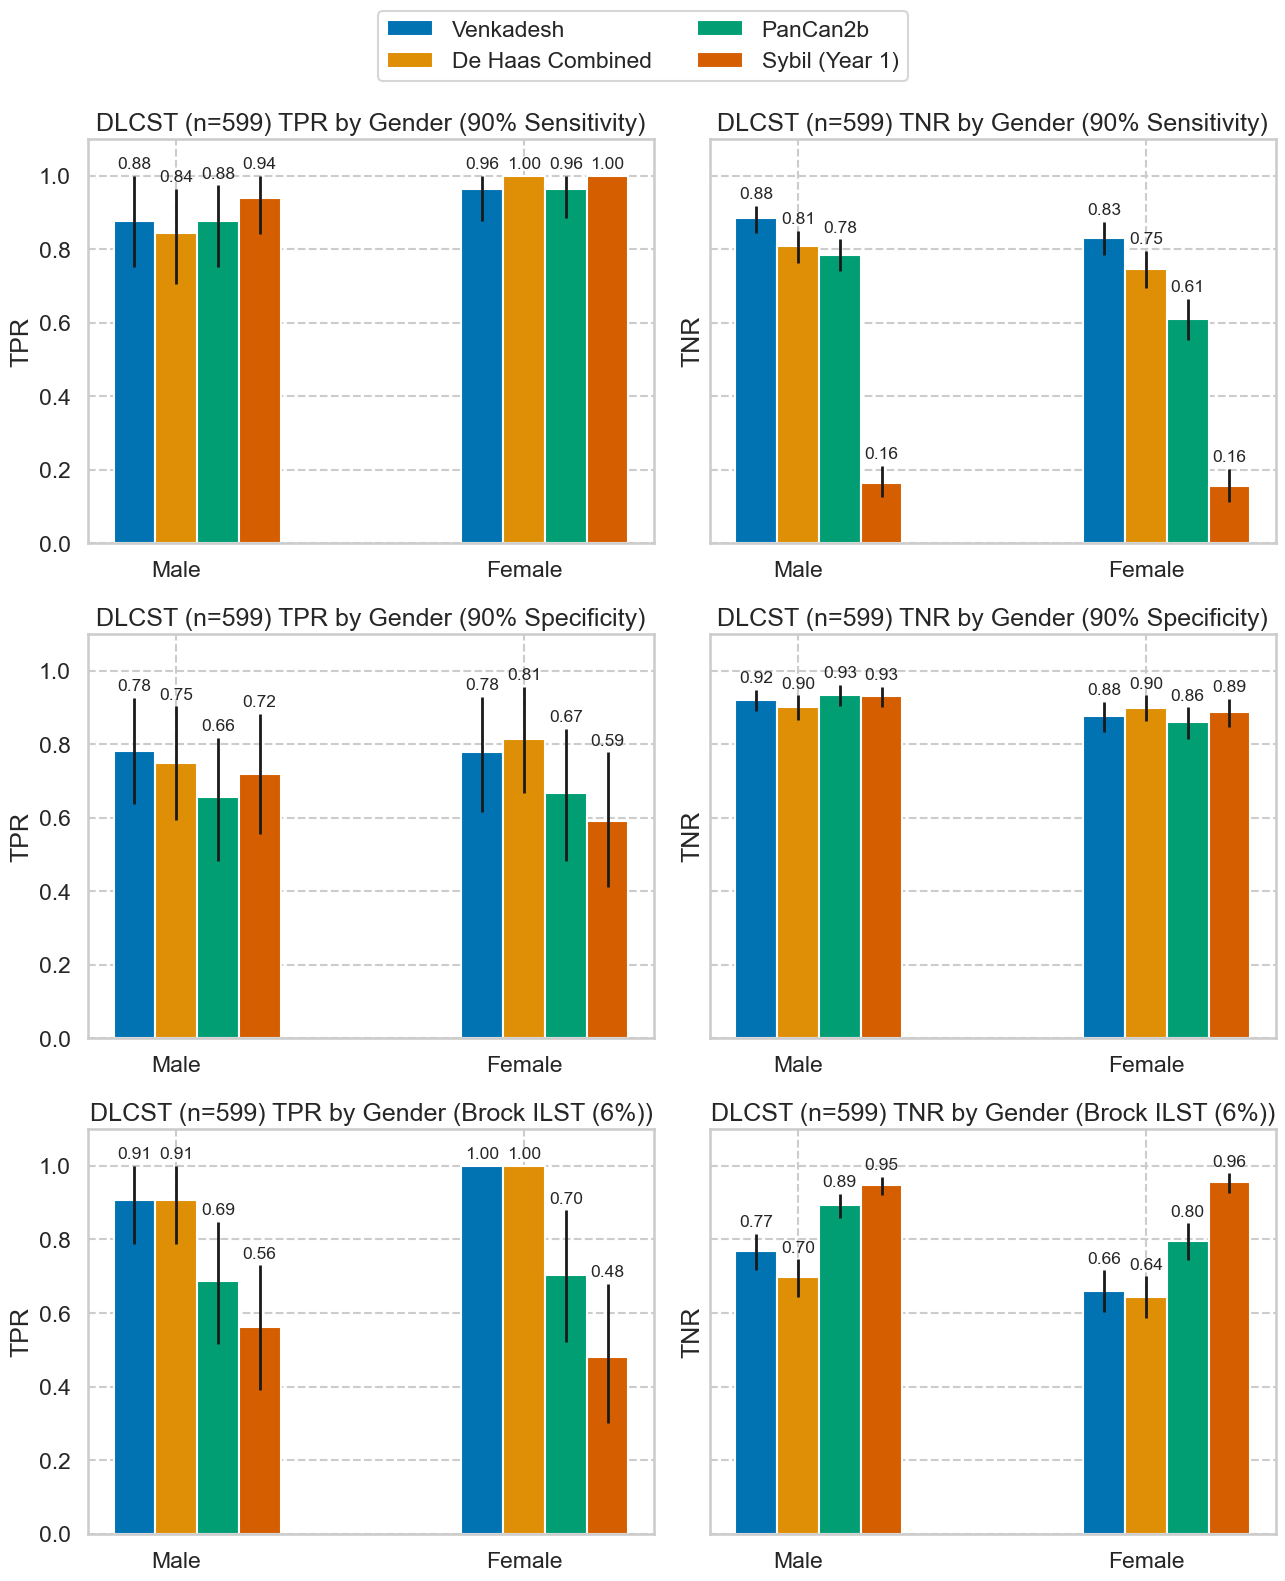

In [81]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Gender', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Gender"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

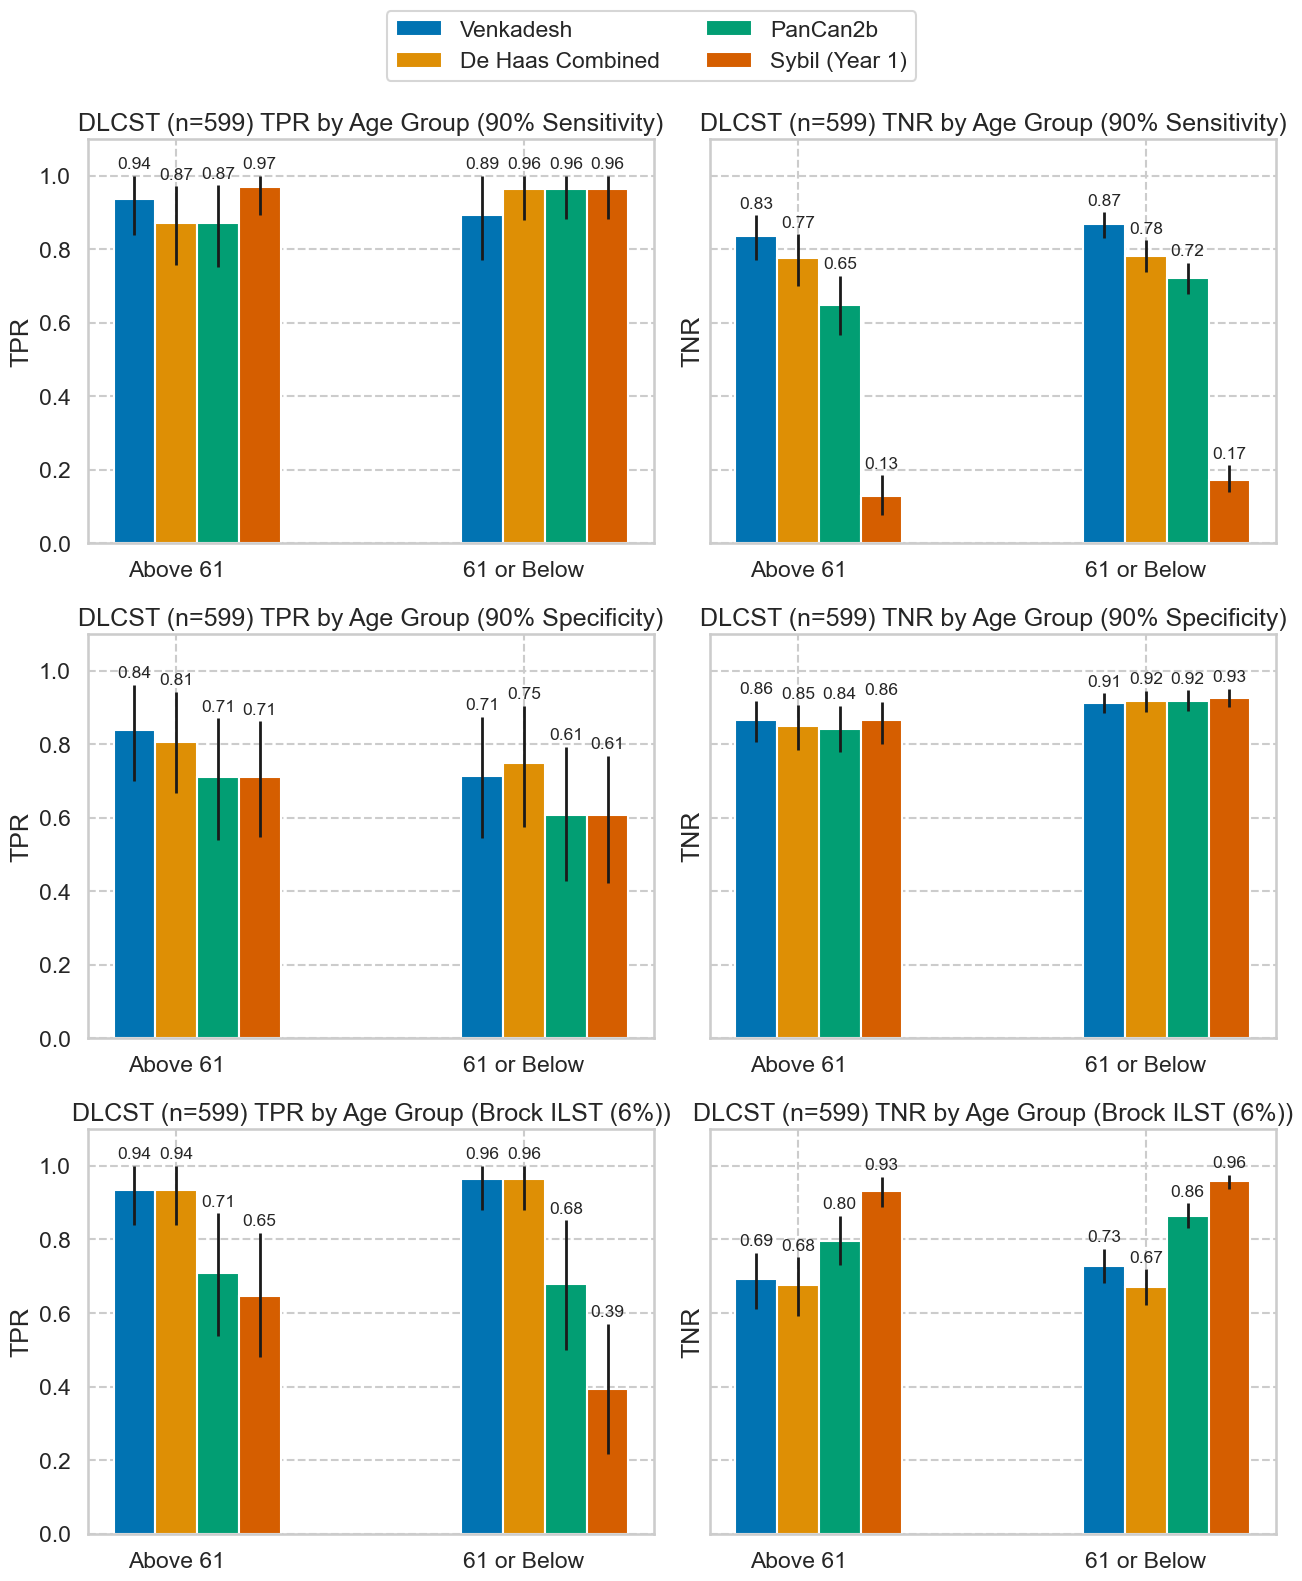

In [82]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age Group', dataset_name='DLCST',
                                             policies=dlcst_policies, models=DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age Group"'),
                                             plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST (1172)

In [83]:
threshold_nlst_1172 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-1172.csv', index_col=0)
threshold_nlst_1172, nlst_1172_policies = threshold_results_pretty(threshold_nlst_1172, nlst_1172_policies)
display(nlst_1172_policies)
display(threshold_nlst_1172[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
NLST_1172_MODELCOLS

,90% Sensitivity,90% Specificity,Brock ILST (6%)
Venkadesh,0.026,0.229,0.06
De Haas Combined,0.069,0.261,0.06
De Haas Local,0.049,0.214,0.06
De Haas Global (Hidden Nodule),0.060,0.235,0.06
De Haas Global (Shown Nodule),0.038,0.308,0.06
Sybil (Year 1),0.003,0.058,0.06
PanCan2b,0.014,0.168,0.06


,category,attribute,group,policy,model,FPR,FPR_lo,FPR_hi
0,Demographics,Age Group,ALL,90% Sensitivity,Venkadesh,0.464115,0.434657,0.494392
1,Demographics,Age Group,ALL,90% Sensitivity,De Haas Combined,0.364593,0.335270,0.394464
2,Demographics,Age Group,ALL,90% Sensitivity,De Haas Local,0.387560,0.357886,0.415386
3,Demographics,Age Group,ALL,90% Sensitivity,De Haas Global (Hidden Nodule),0.484211,0.454455,0.514163
4,Demographics,Age Group,ALL,90% Sensitivity,De Haas Global (Shown Nodule),0.481340,0.449802,0.511562
...,...,...,...,...,...,...,...,...
590,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Local,0.364807,0.301703,0.427366
591,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Global (Hidden Nodule),0.454936,0.392033,0.519153
592,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Global (Shown Nodule),0.330472,0.274334,0.390761
593,Scanner,Model Name,Volume Zoom,Brock ILST (6%),Sybil (Year 1),0.090129,0.055079,0.127778


{'Venkadesh': 'DL_cal',
 'De Haas Combined': 'Thijmen_mean_cal',
 'De Haas Local': 'Thijmen_local_cal',
 'De Haas Global (Hidden Nodule)': 'Thijmen_global_hidden_cal',
 'De Haas Global (Shown Nodule)': 'Thijmen_global_show_cal',
 'Sybil (Year 1)': 'sybil_year1',
 'PanCan2b': 'PanCan2b'}

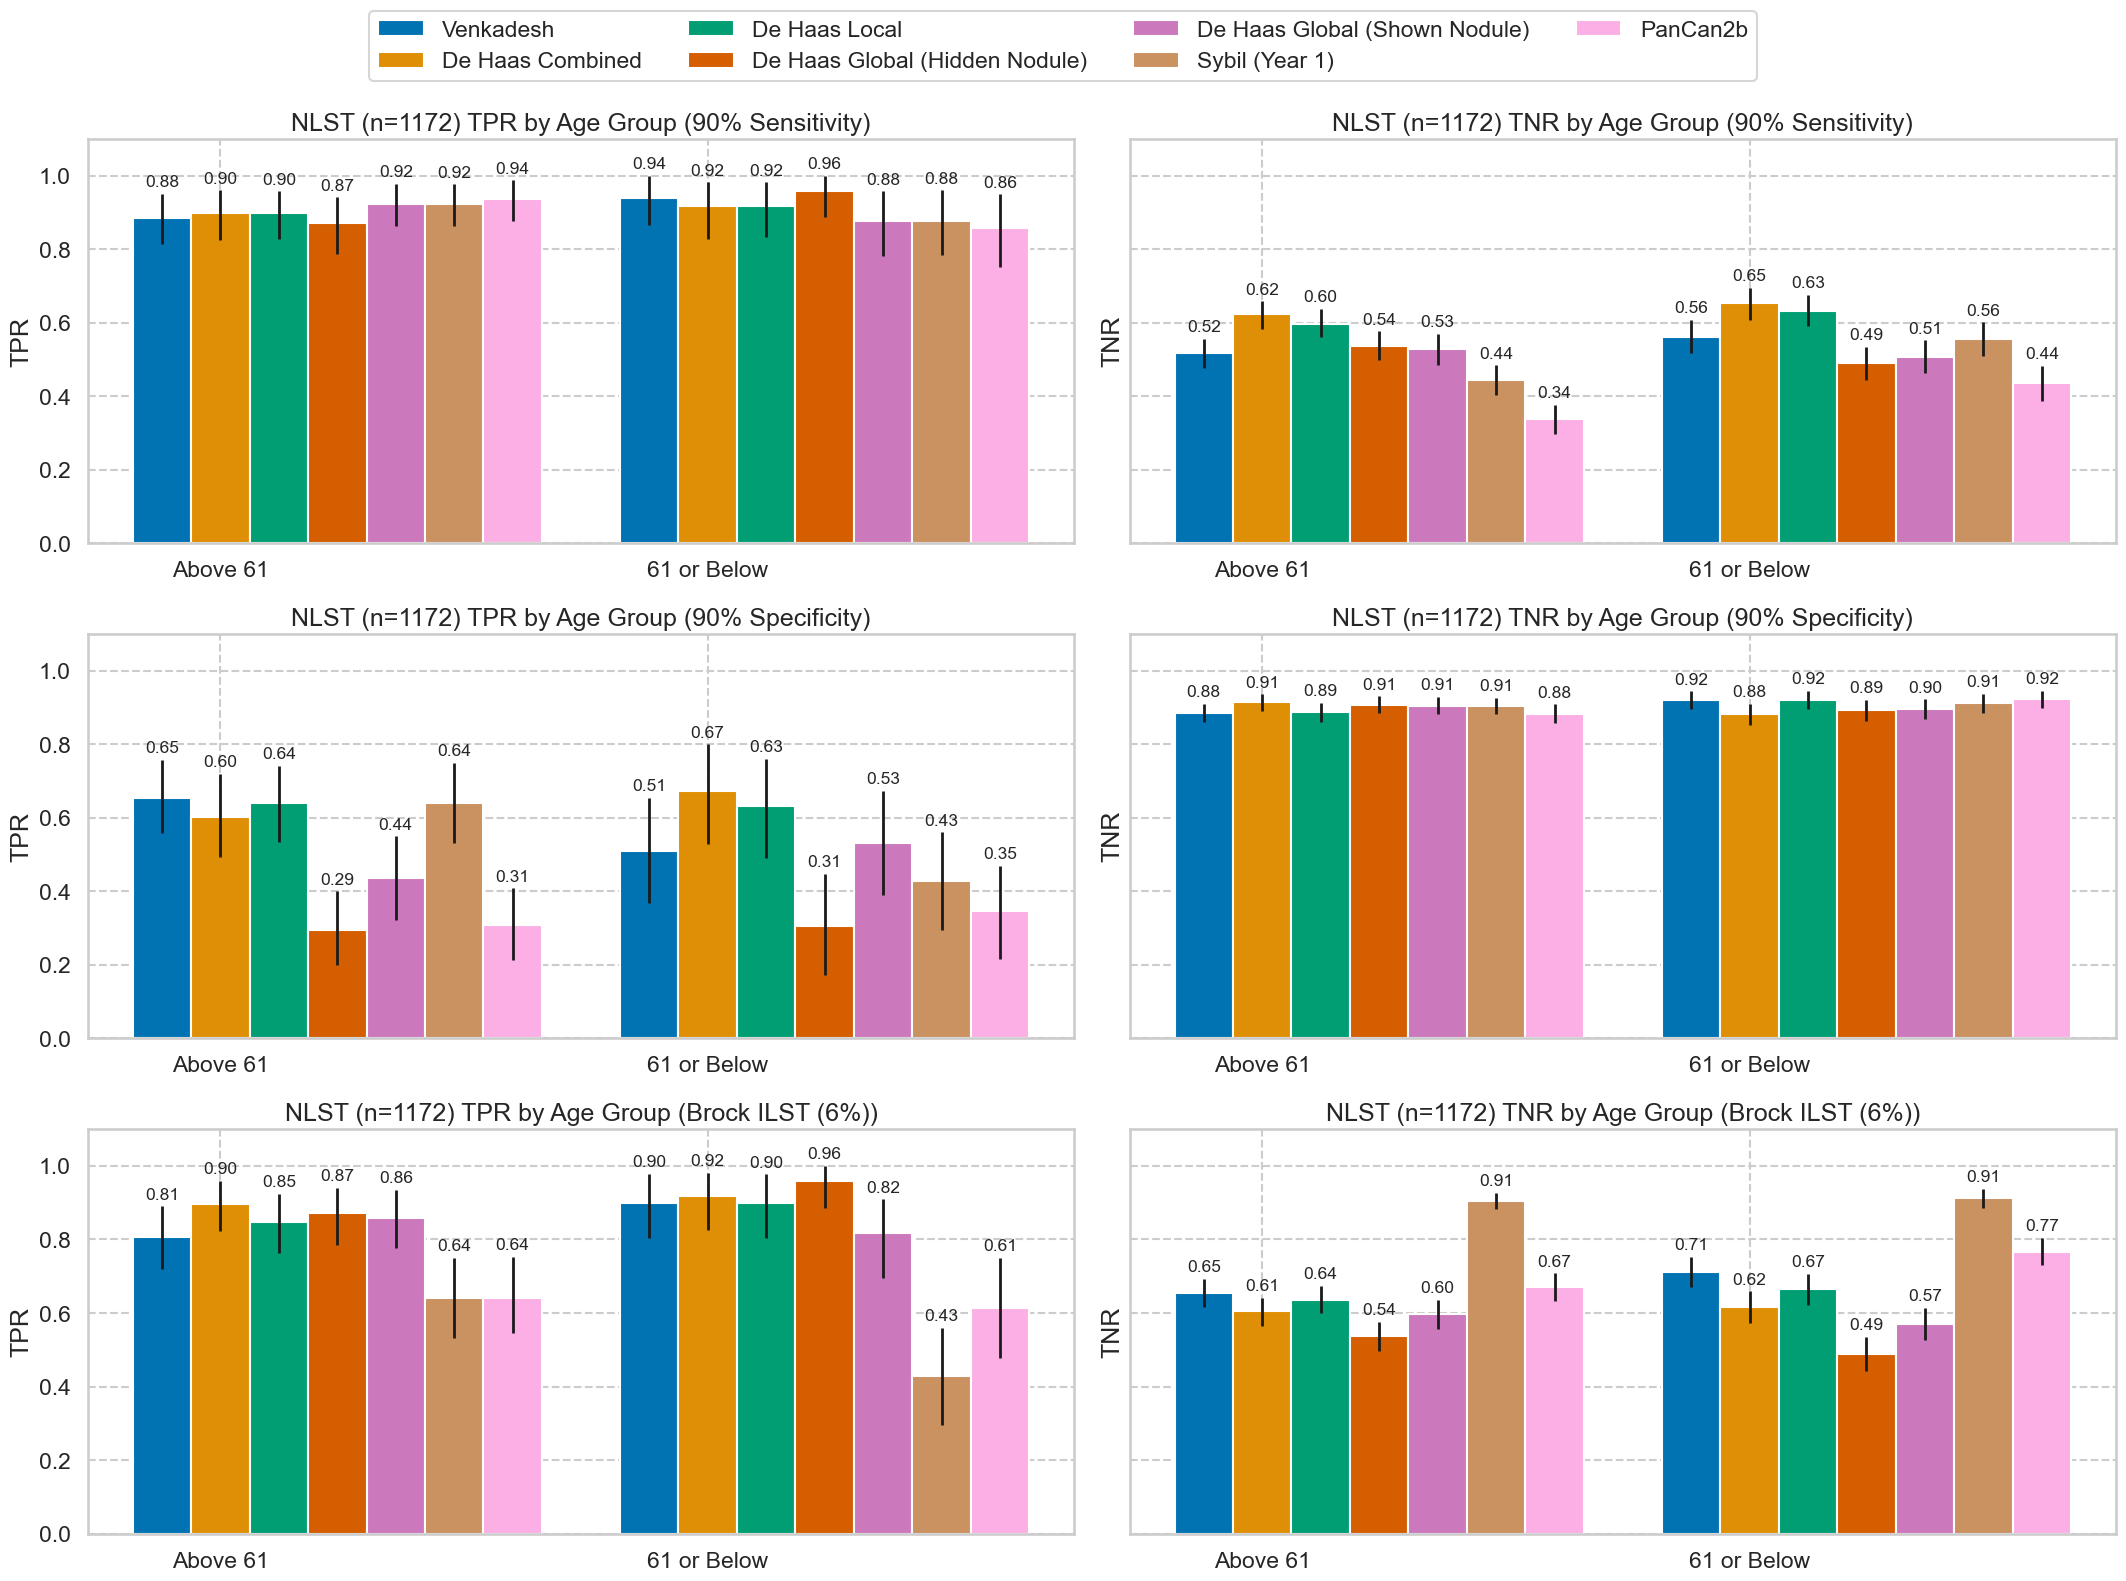

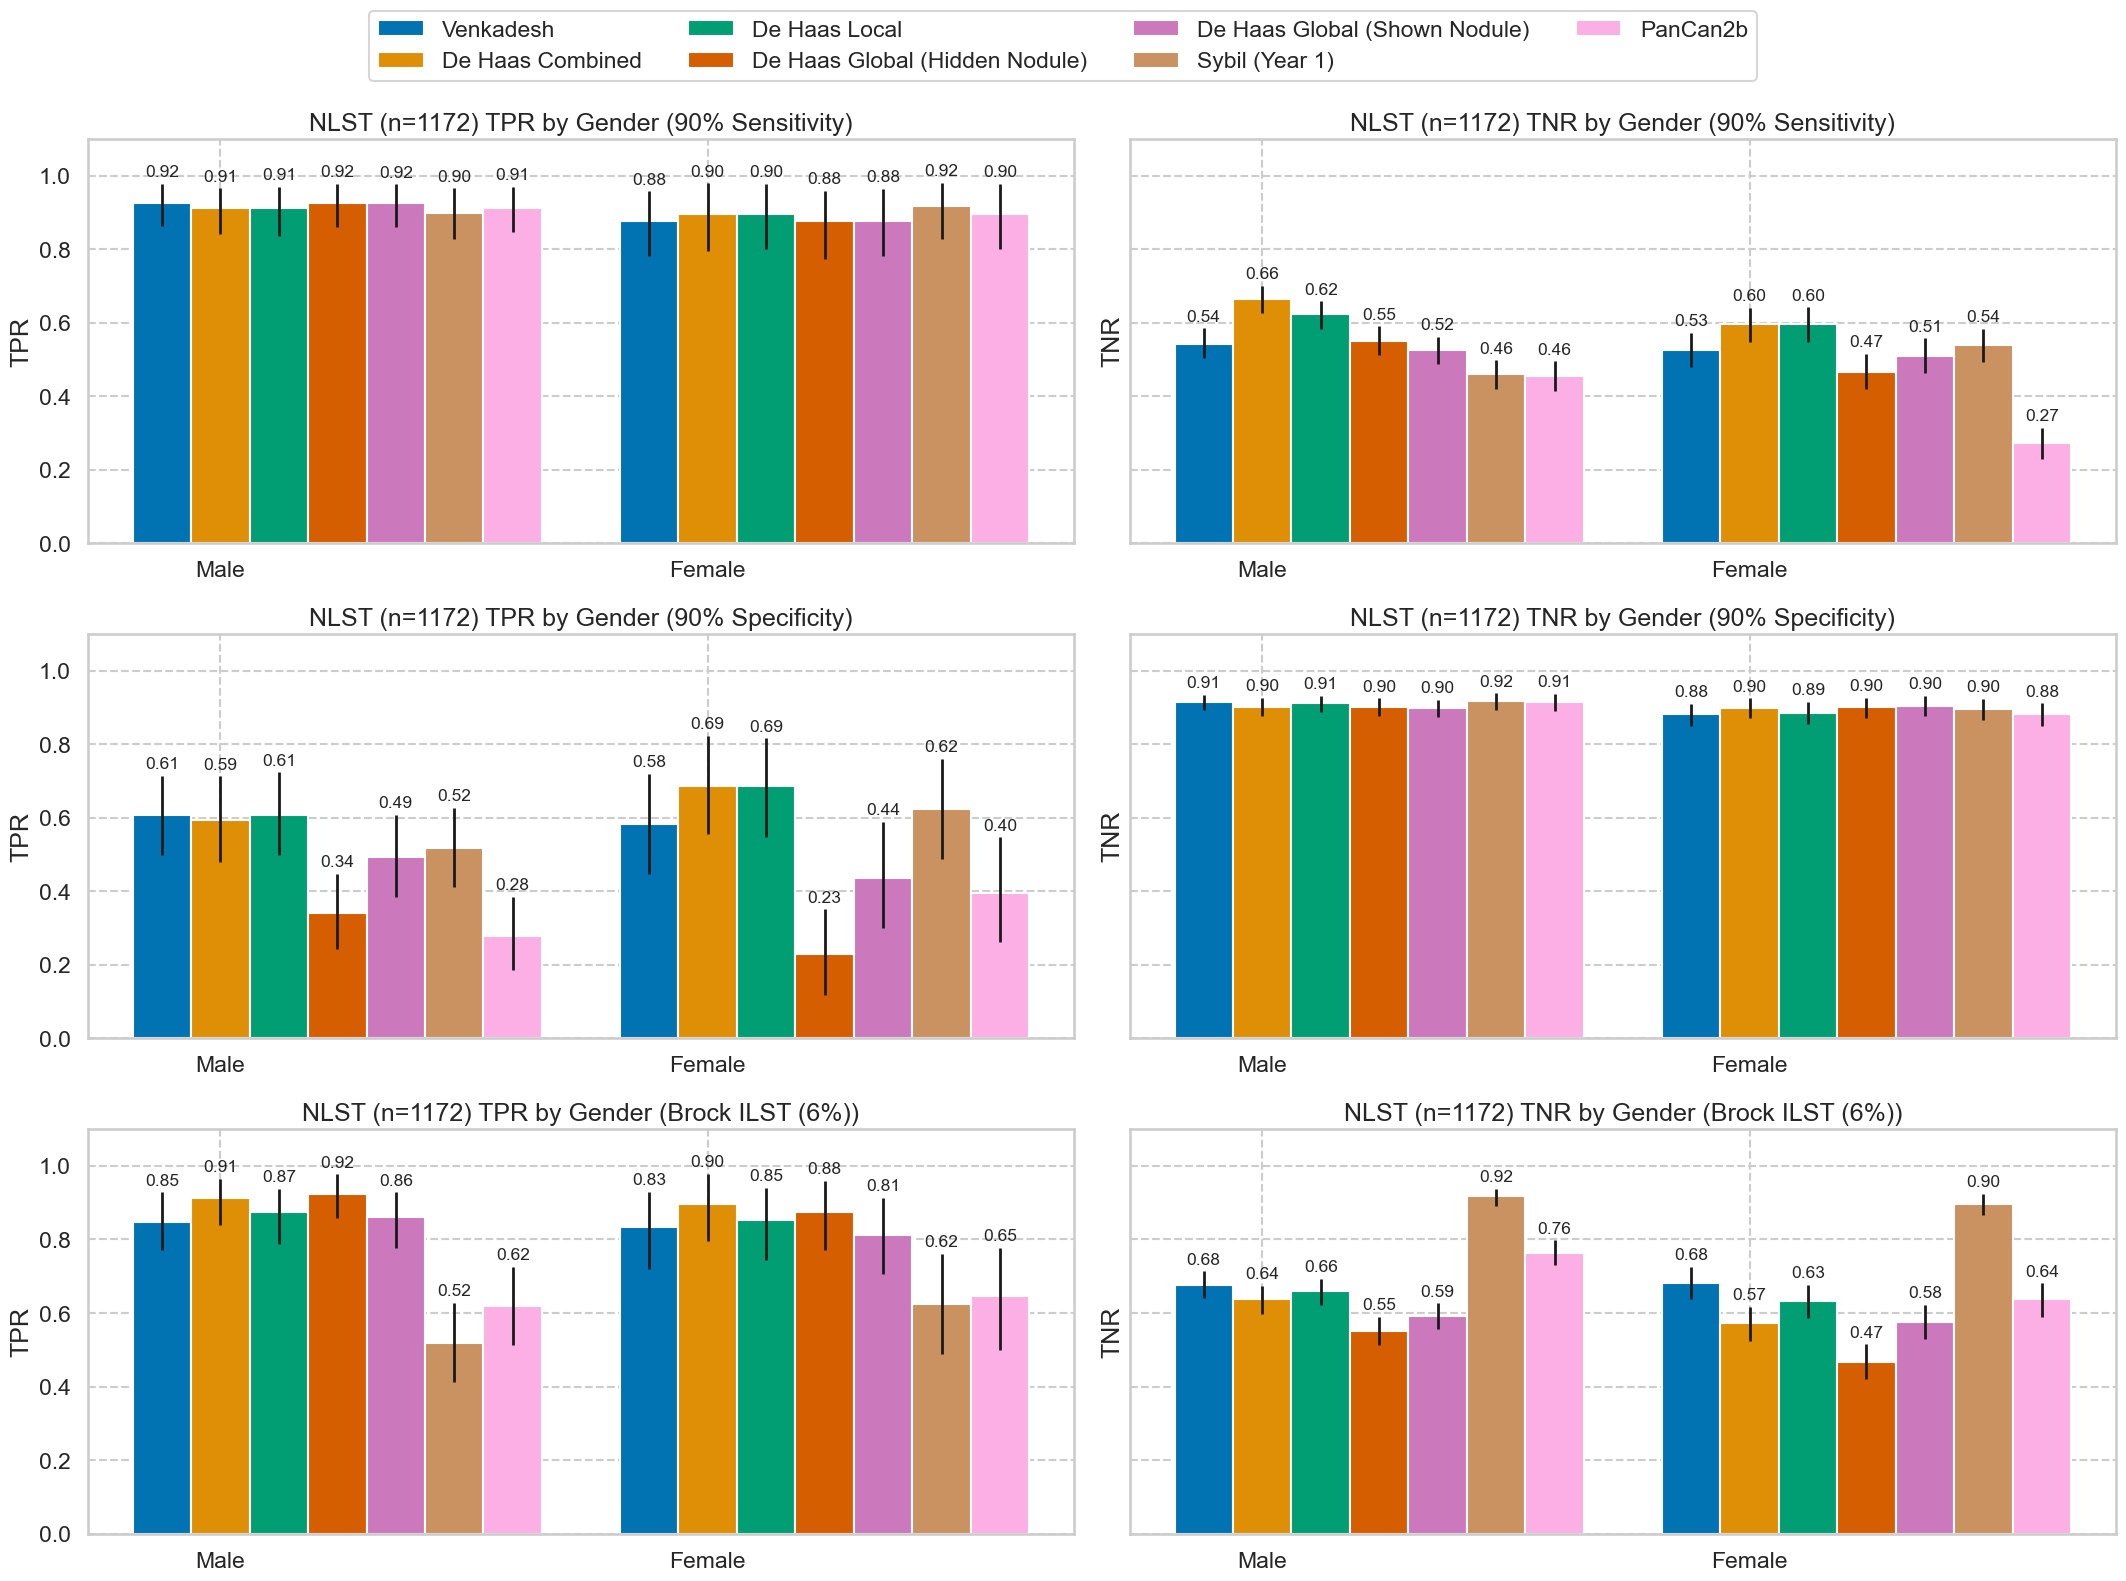

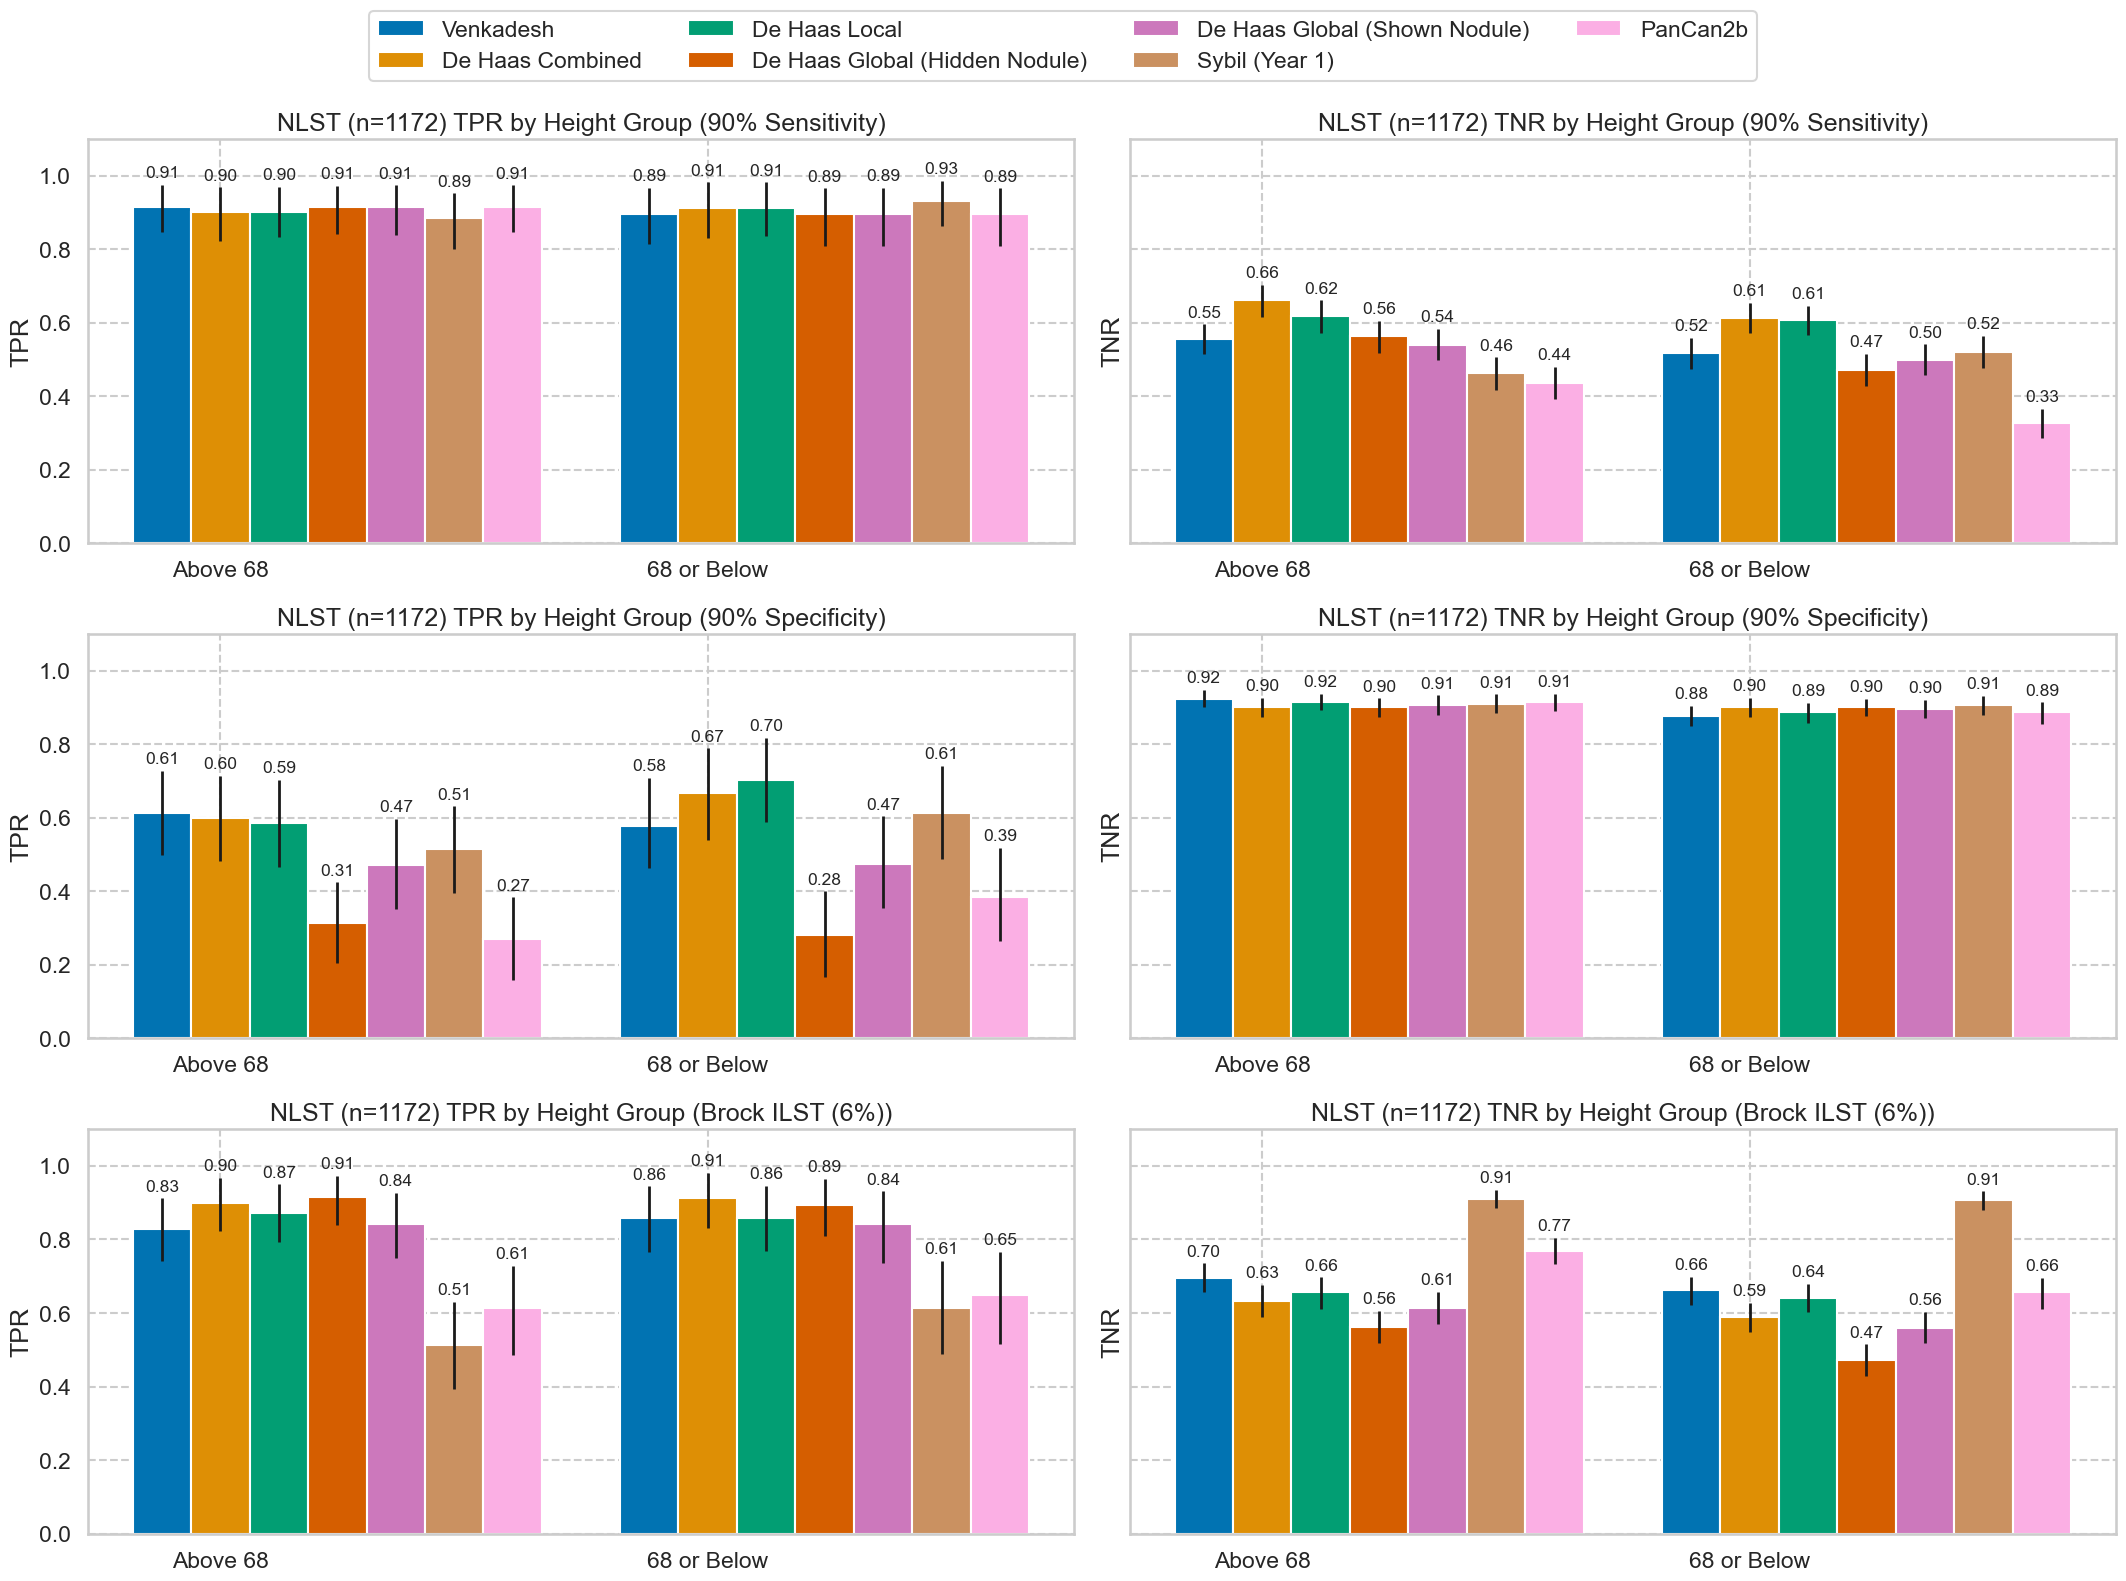

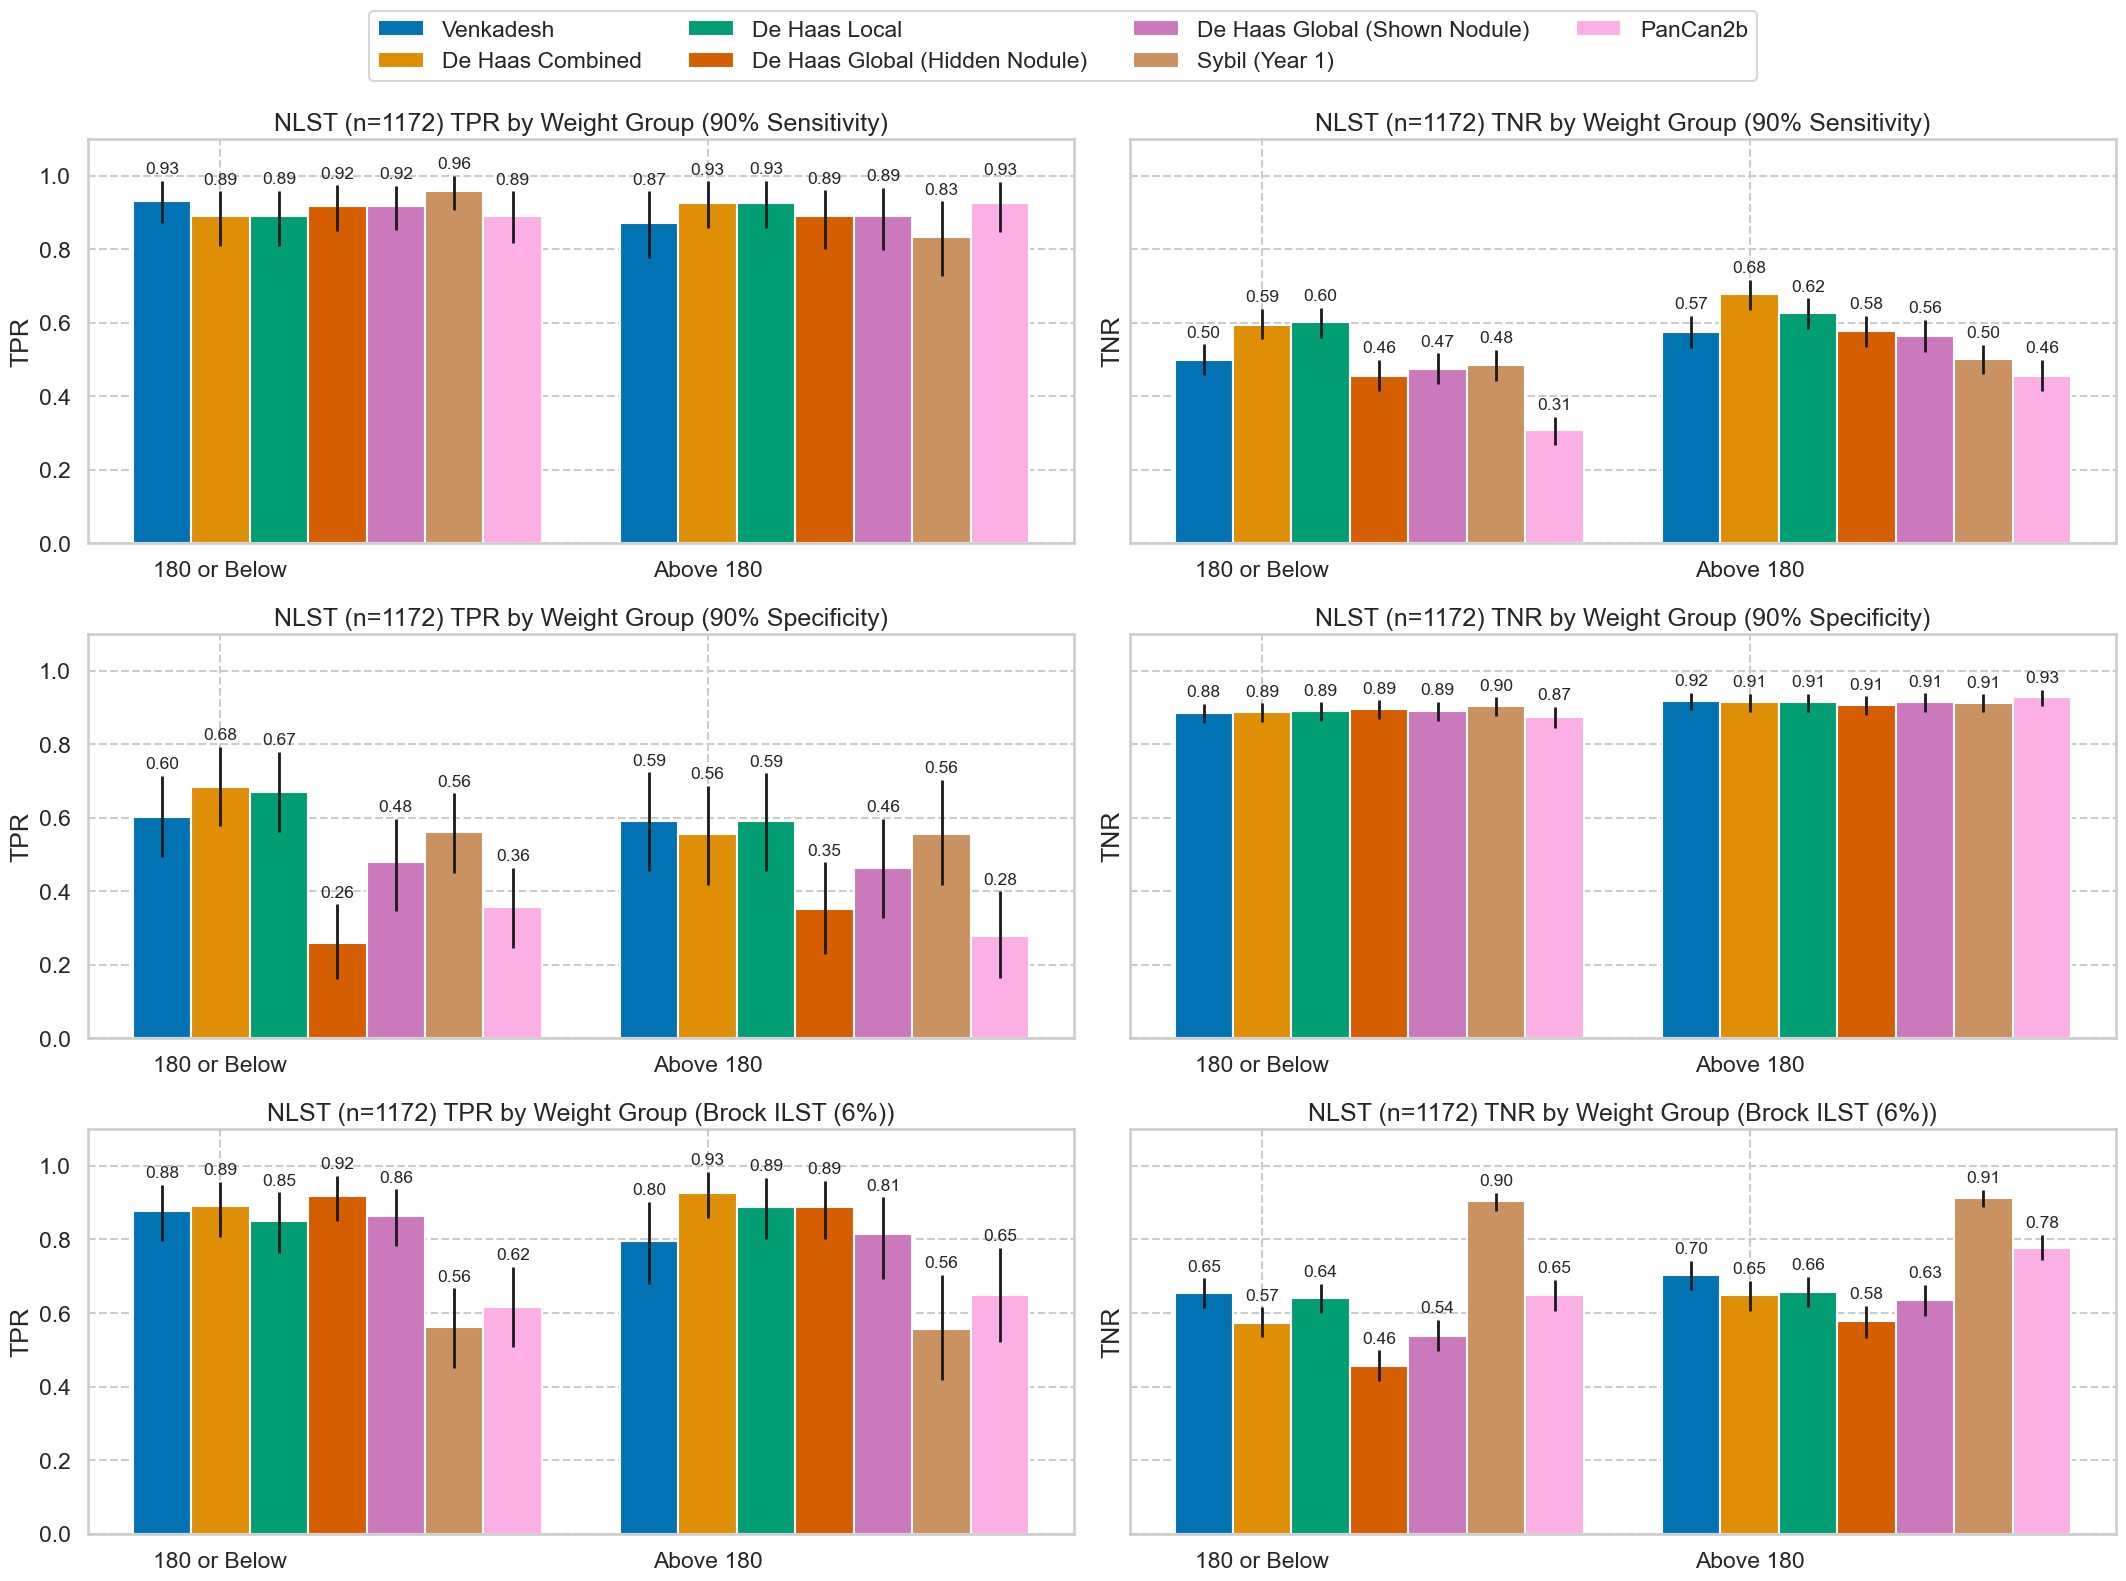

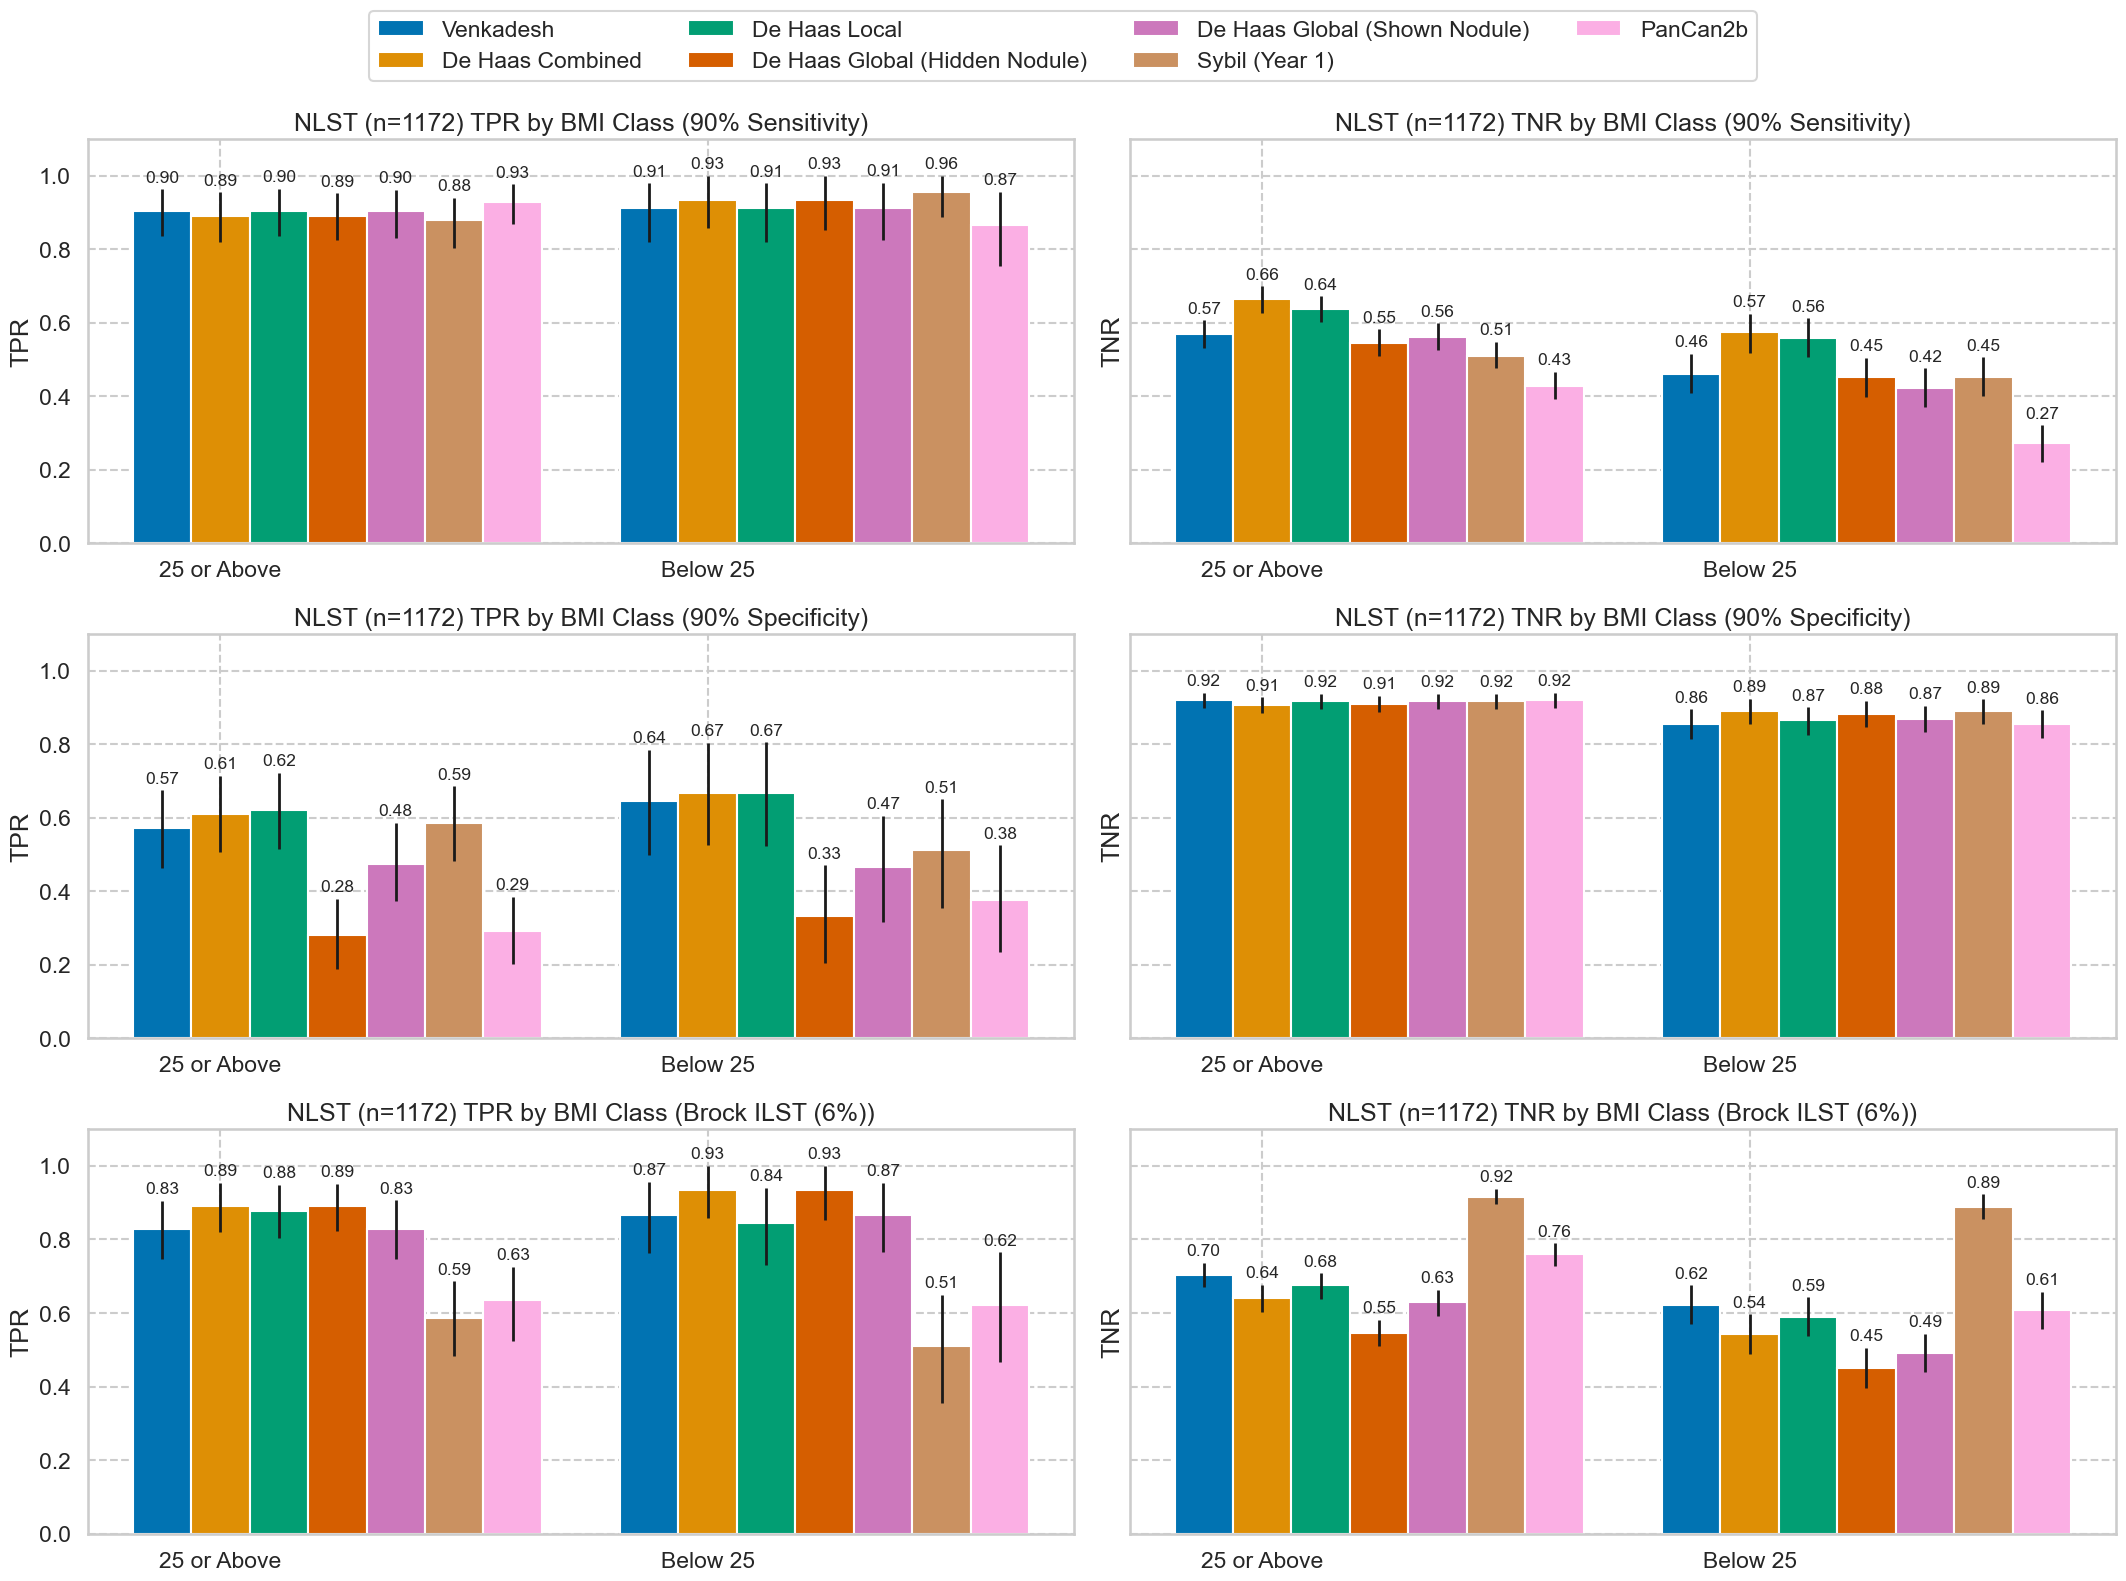

In [84]:
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_1172, col, dataset_name='NLST',
                                                policies=nlst_1172_policies, models=NLST_1172_MODELCOLS, 
                                                stats=threshold_nlst_1172.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-1172/{col}.png"
                                                )  

### NLST 5911


In [85]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = threshold_results_pretty(threshold_nlst_5911, nlst_5911_policies)
display(nlst_5911_policies)
display(threshold_nlst_5911[['category', 'attribute', 'group', 'policy', 'model', 'FPR', 'FPR_lo', 'FPR_hi']])
NLST_5911_MODELCOLS

,90% Sensitivity,90% Specificity,Brock ILST (6%)
Venkadesh,0.048,0.220,0.06
De Haas Local,0.044,0.212,0.06
De Haas Global (Hidden Nodule),0.066,0.241,0.06
De Haas Global (Shown Nodule),0.068,0.300,0.06
Sybil (Year 1),0.003,0.058,0.06
PanCan2b,0.015,0.165,0.06


,category,attribute,group,policy,model,FPR,FPR_lo,FPR_hi
0,Demographics,Age Group,ALL,90% Sensitivity,Venkadesh,0.339024,0.326499,0.350815
1,Demographics,Age Group,ALL,90% Sensitivity,De Haas Local,0.393058,0.380444,0.406939
2,Demographics,Age Group,ALL,90% Sensitivity,De Haas Global (Hidden Nodule),0.464353,0.451429,0.478512
3,Demographics,Age Group,ALL,90% Sensitivity,De Haas Global (Shown Nodule),0.386304,0.373563,0.400149
4,Demographics,Age Group,ALL,90% Sensitivity,Sybil (Year 1),0.496060,0.483069,0.509017
...,...,...,...,...,...,...,...,...
655,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Local,0.305648,0.279531,0.331984
656,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Global (Hidden Nodule),0.475083,0.445376,0.501255
657,Scanner,Model Name,Volume Zoom,Brock ILST (6%),De Haas Global (Shown Nodule),0.357973,0.331400,0.383407
658,Scanner,Model Name,Volume Zoom,Brock ILST (6%),Sybil (Year 1),0.072259,0.058629,0.087678


{'Venkadesh': 'DL_cal',
 'De Haas Local': 'Thijmen_local_cal',
 'De Haas Global (Hidden Nodule)': 'Thijmen_global_hidden_cal',
 'De Haas Global (Shown Nodule)': 'Thijmen_global_show_cal',
 'Sybil (Year 1)': 'sybil_year1',
 'PanCan2b': 'PanCan2b'}

['Age Group', 'Gender', 'Race', 'HS Education', 'Height Group', 'Weight Group', 'BMI Class']


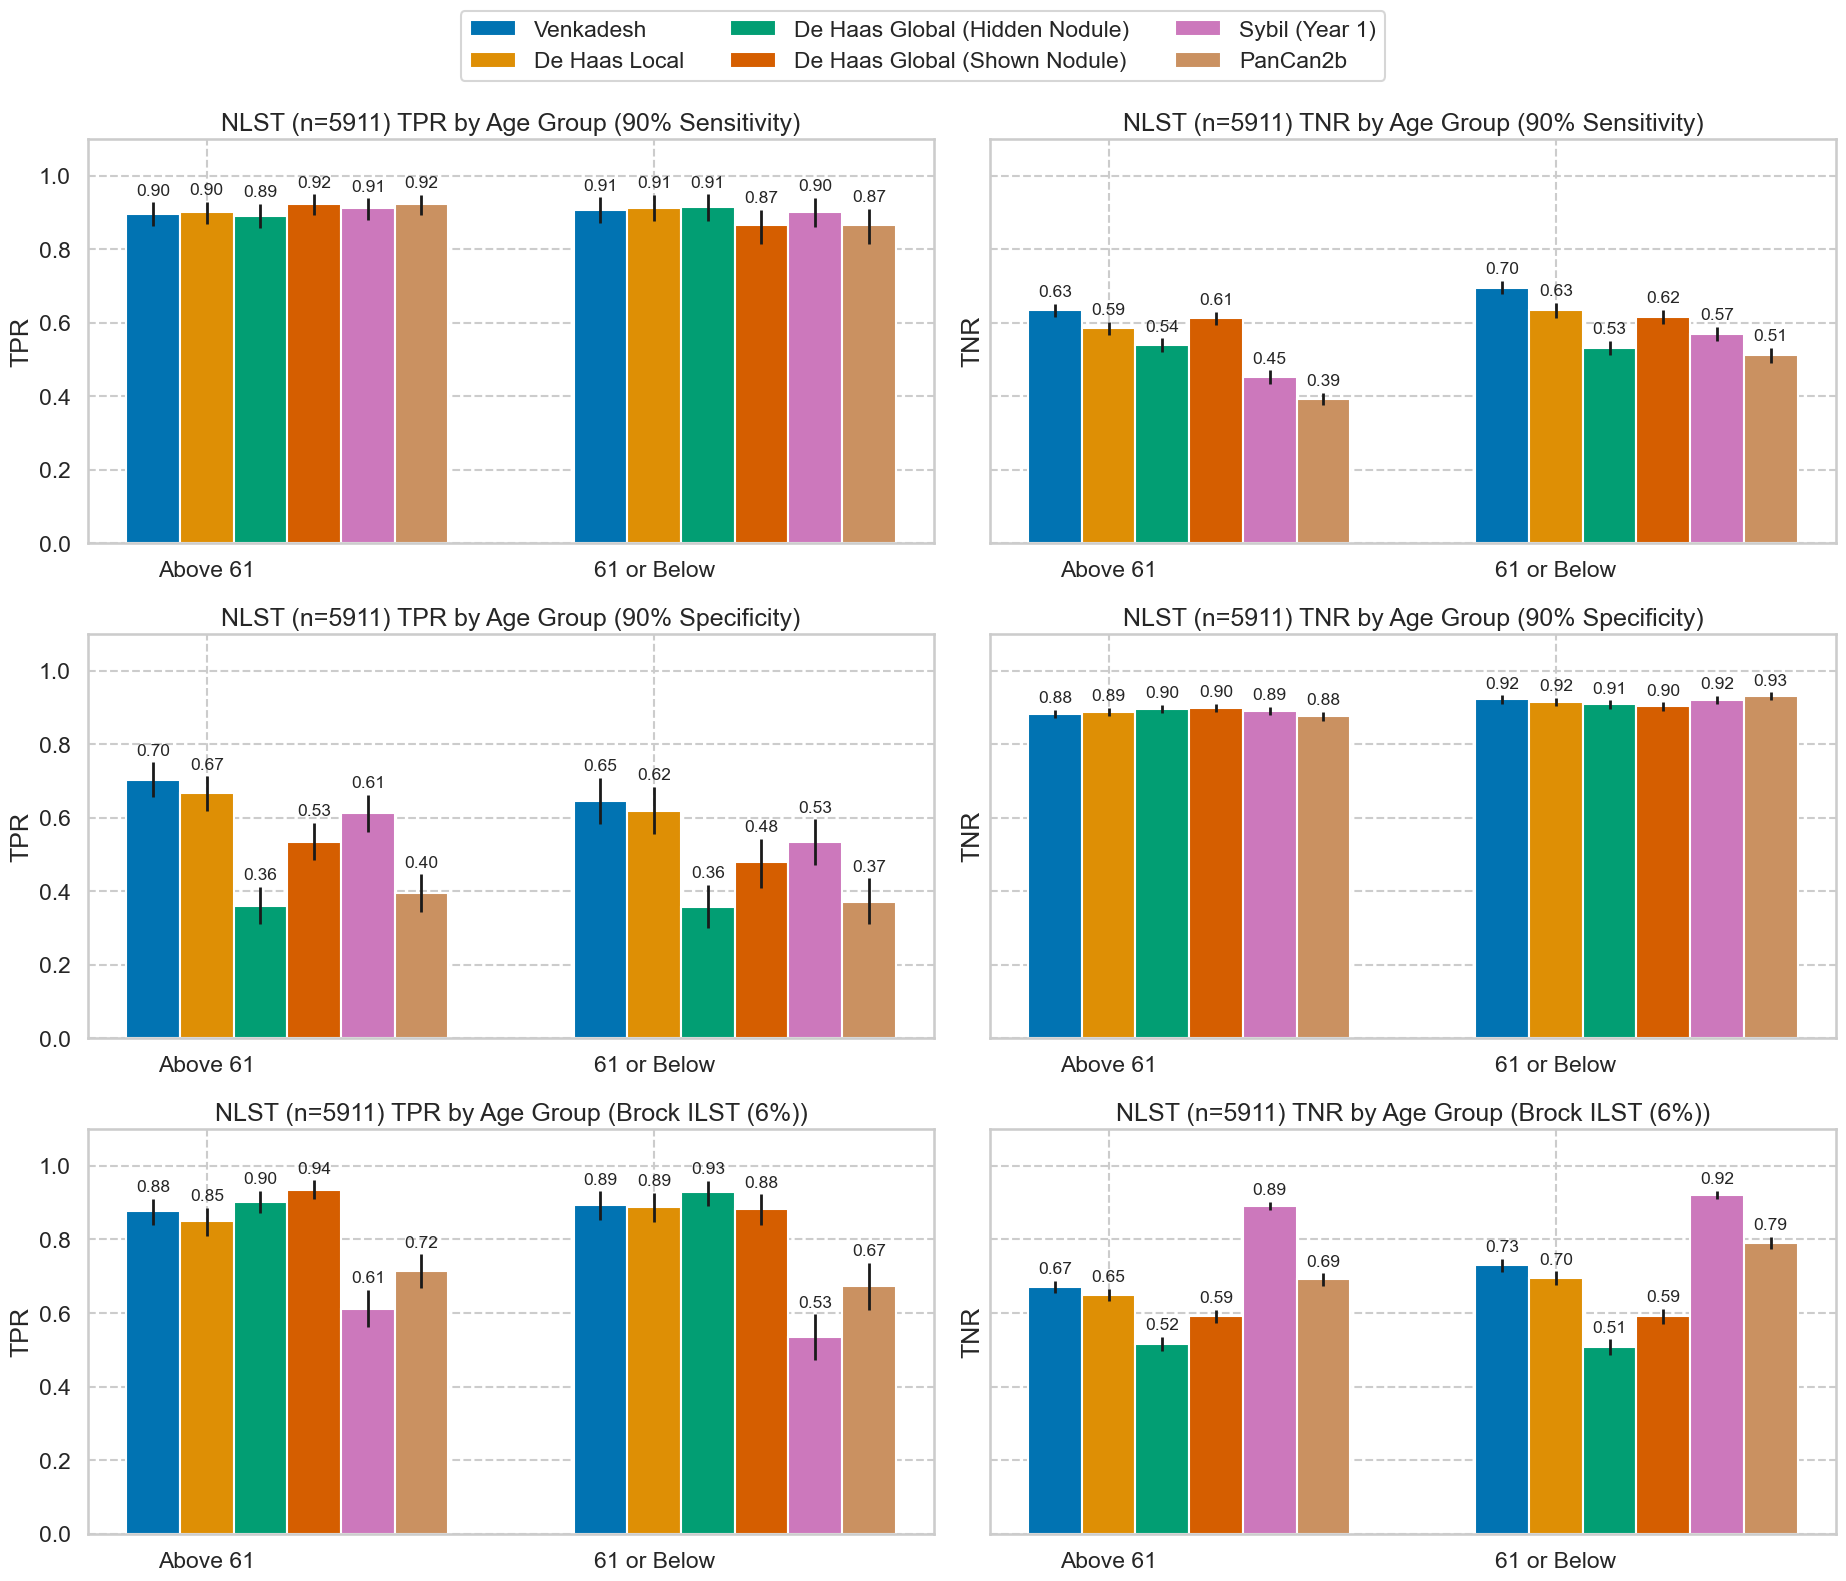

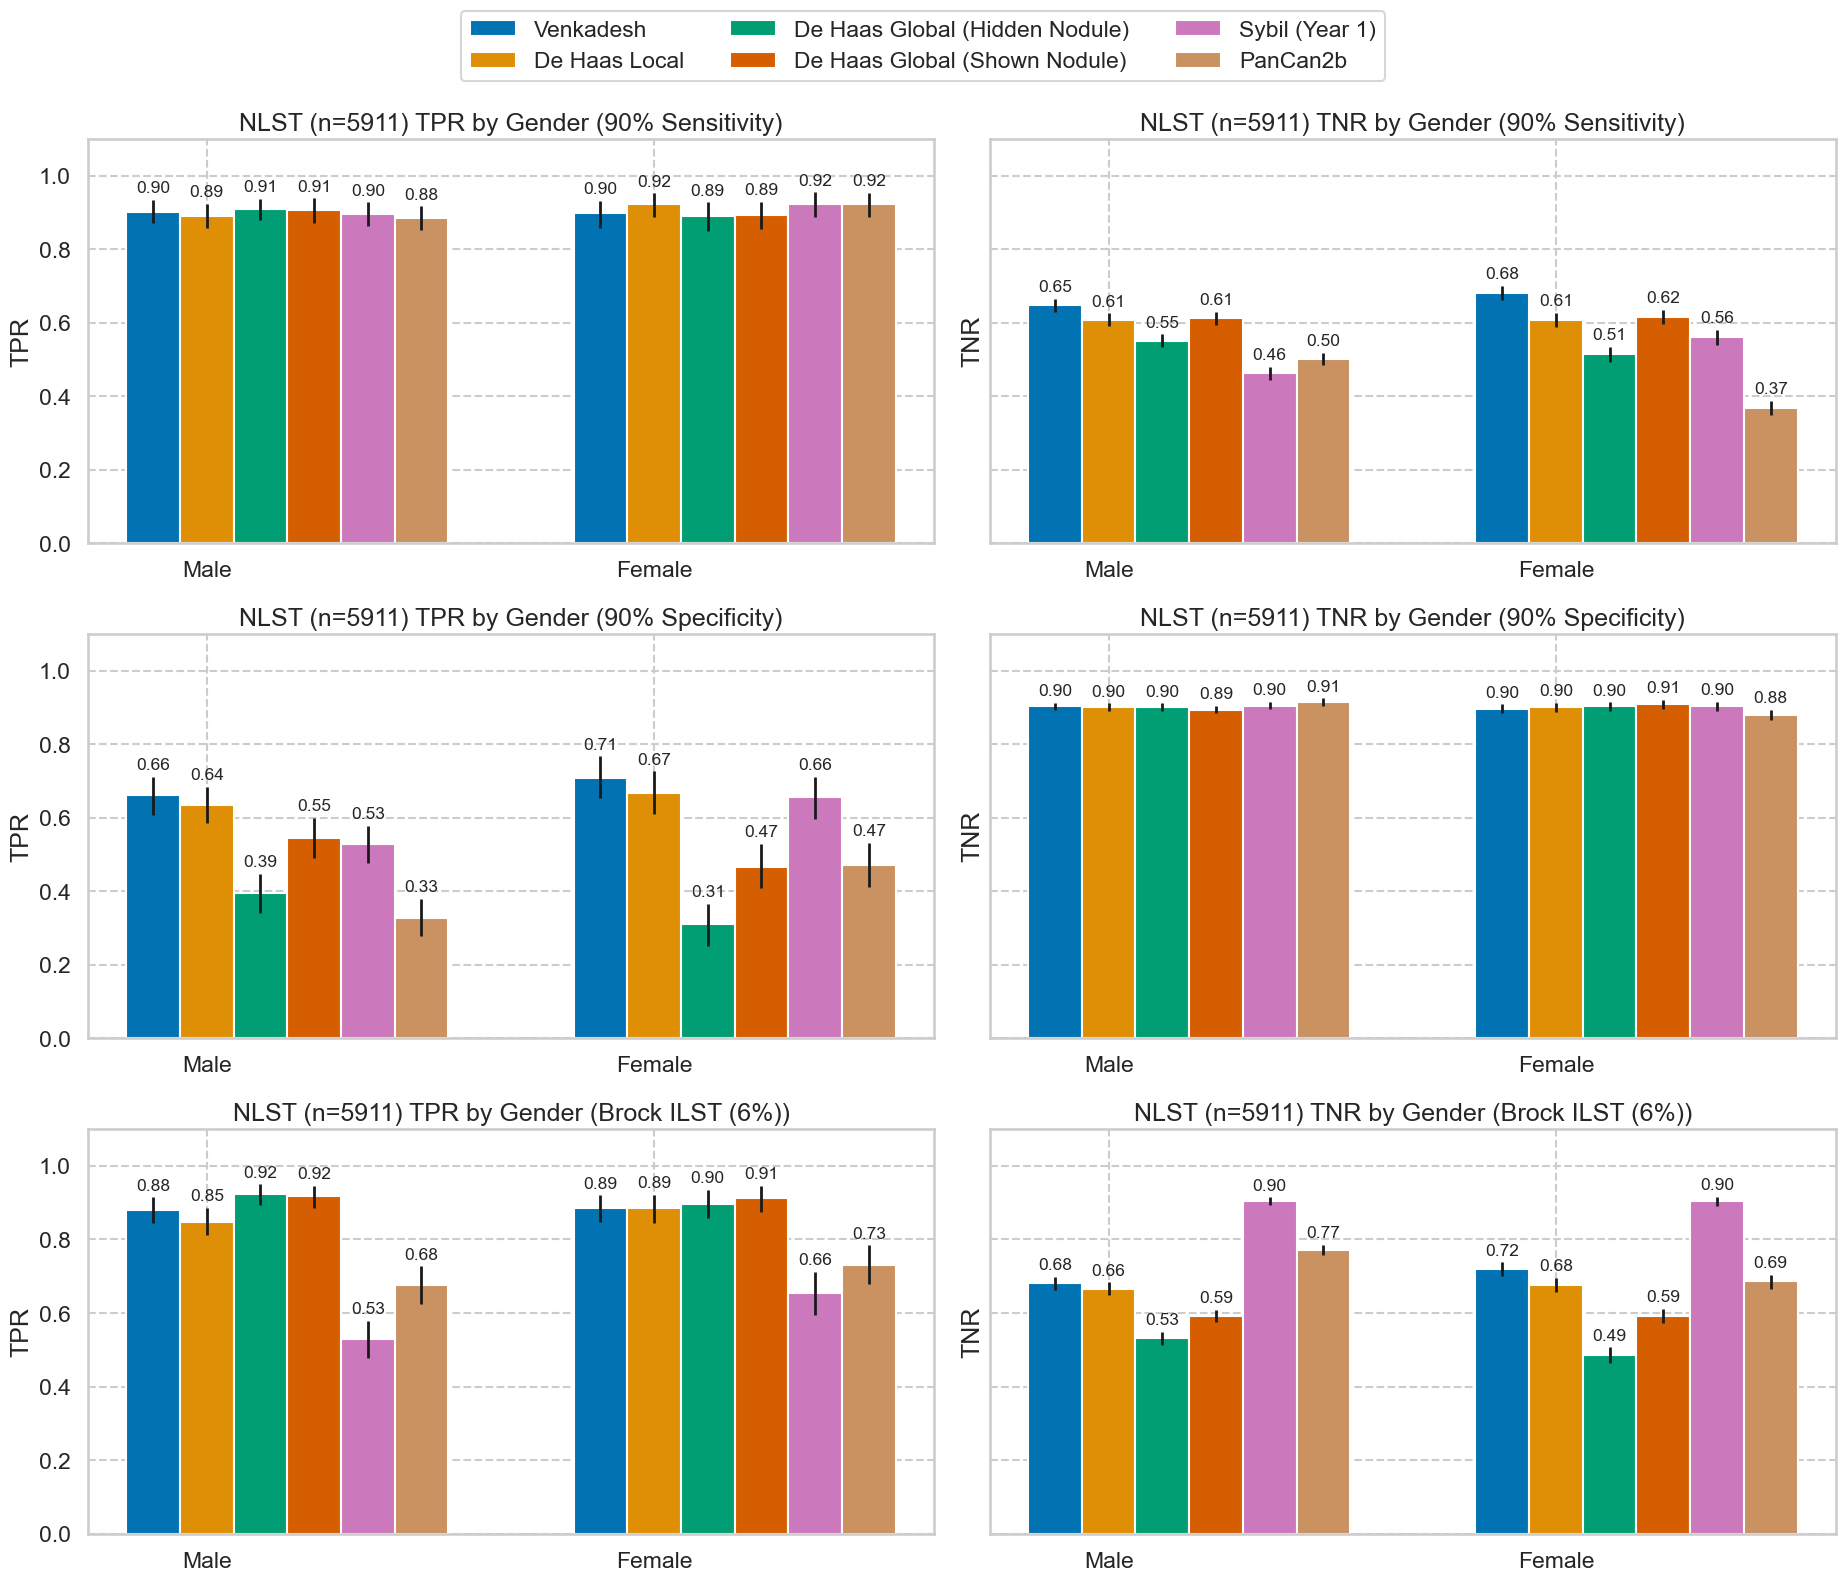

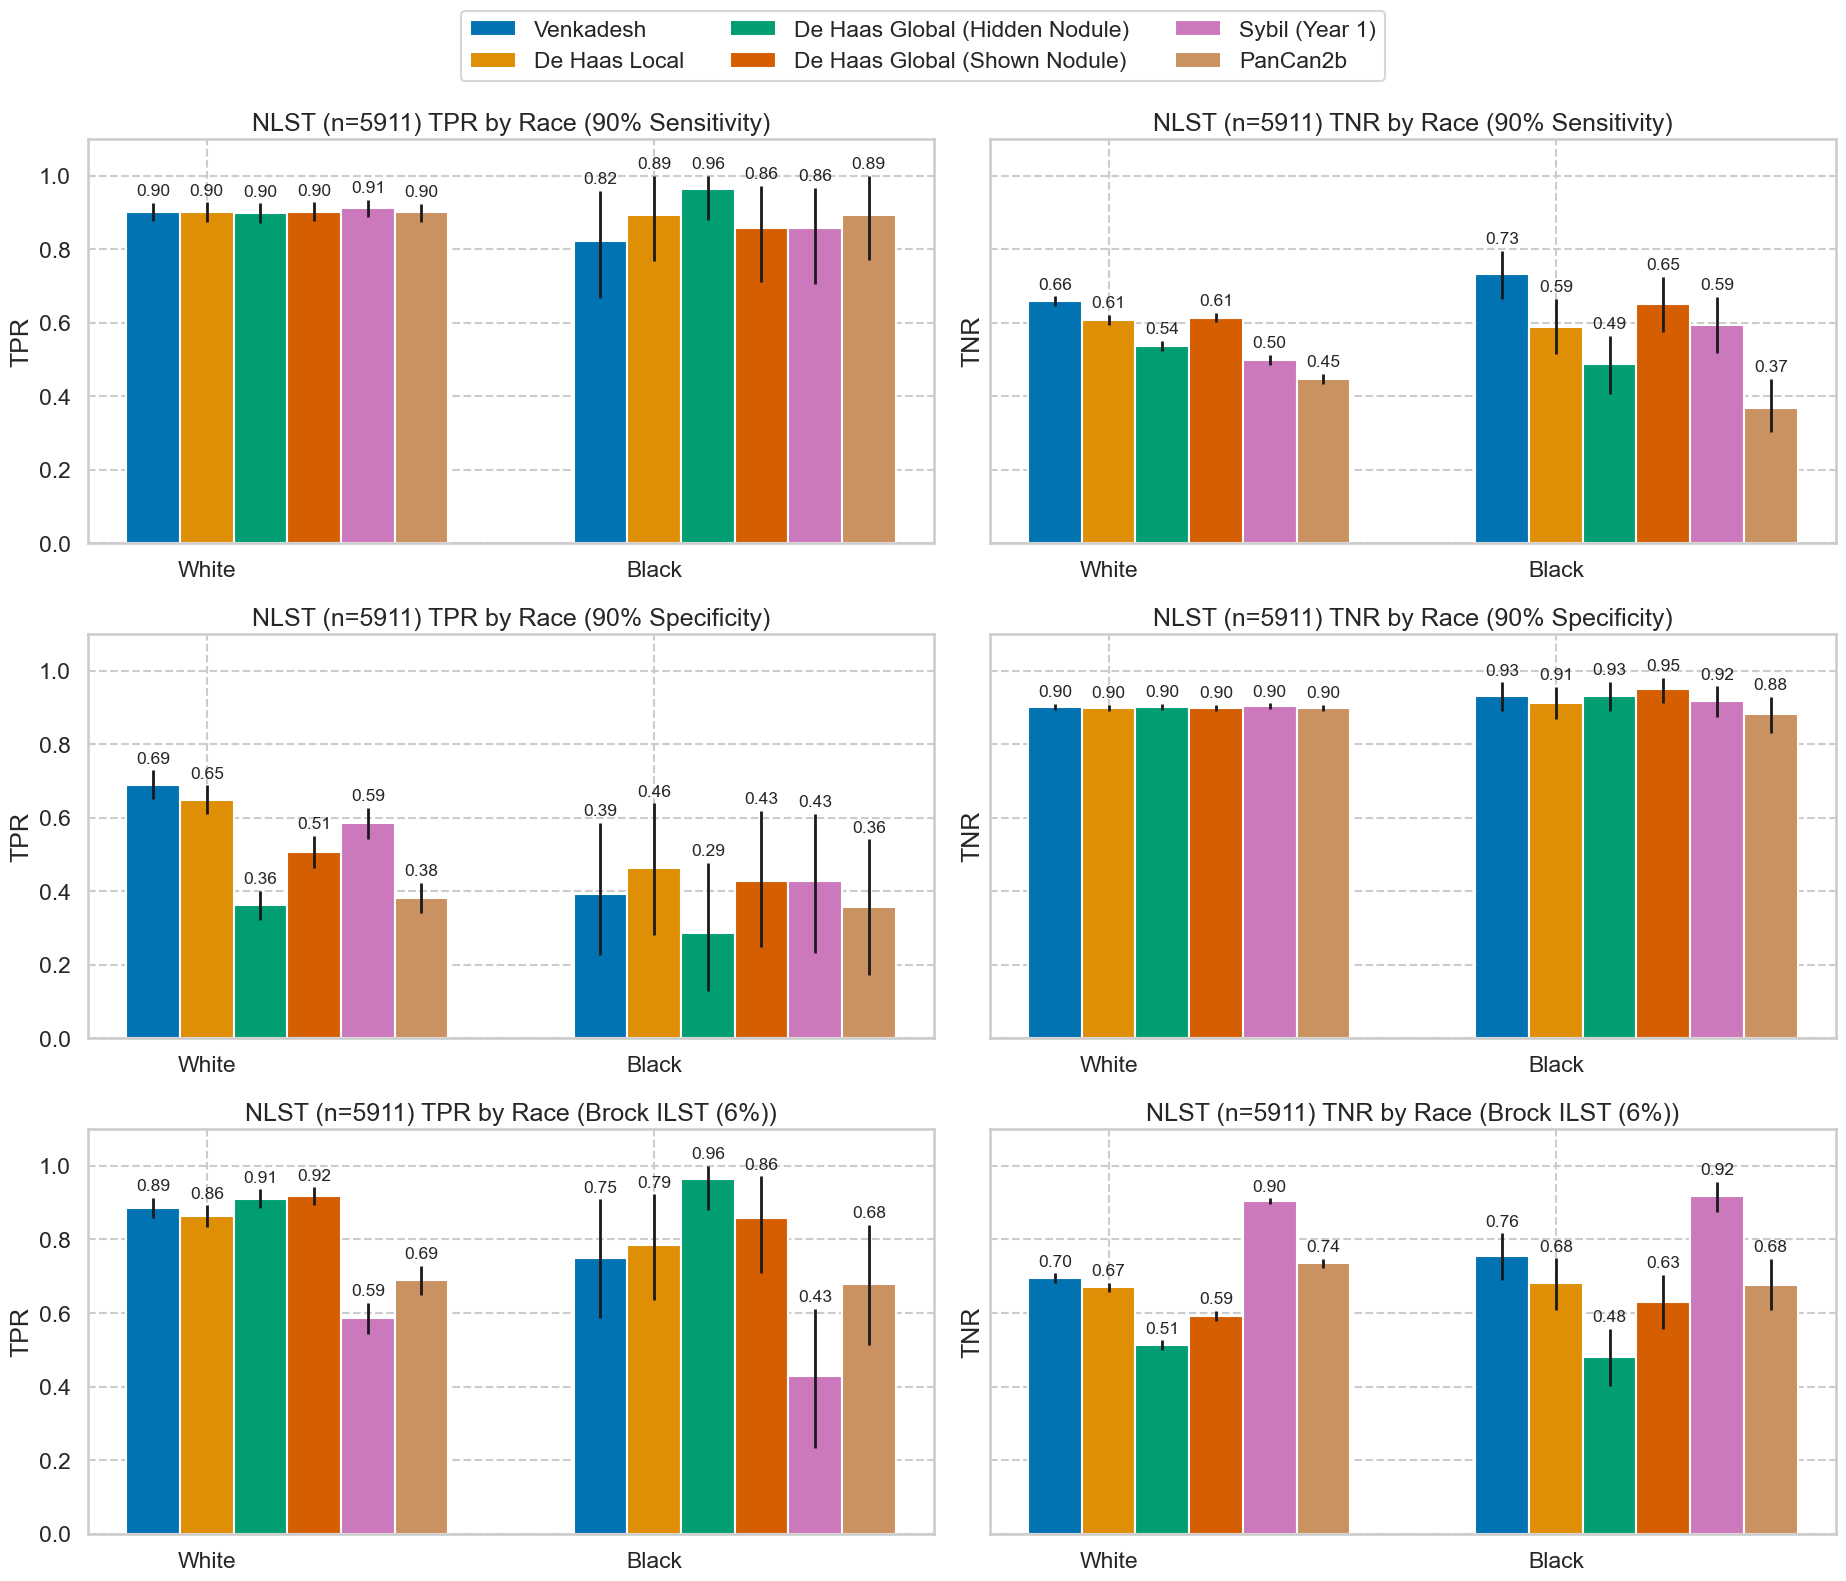

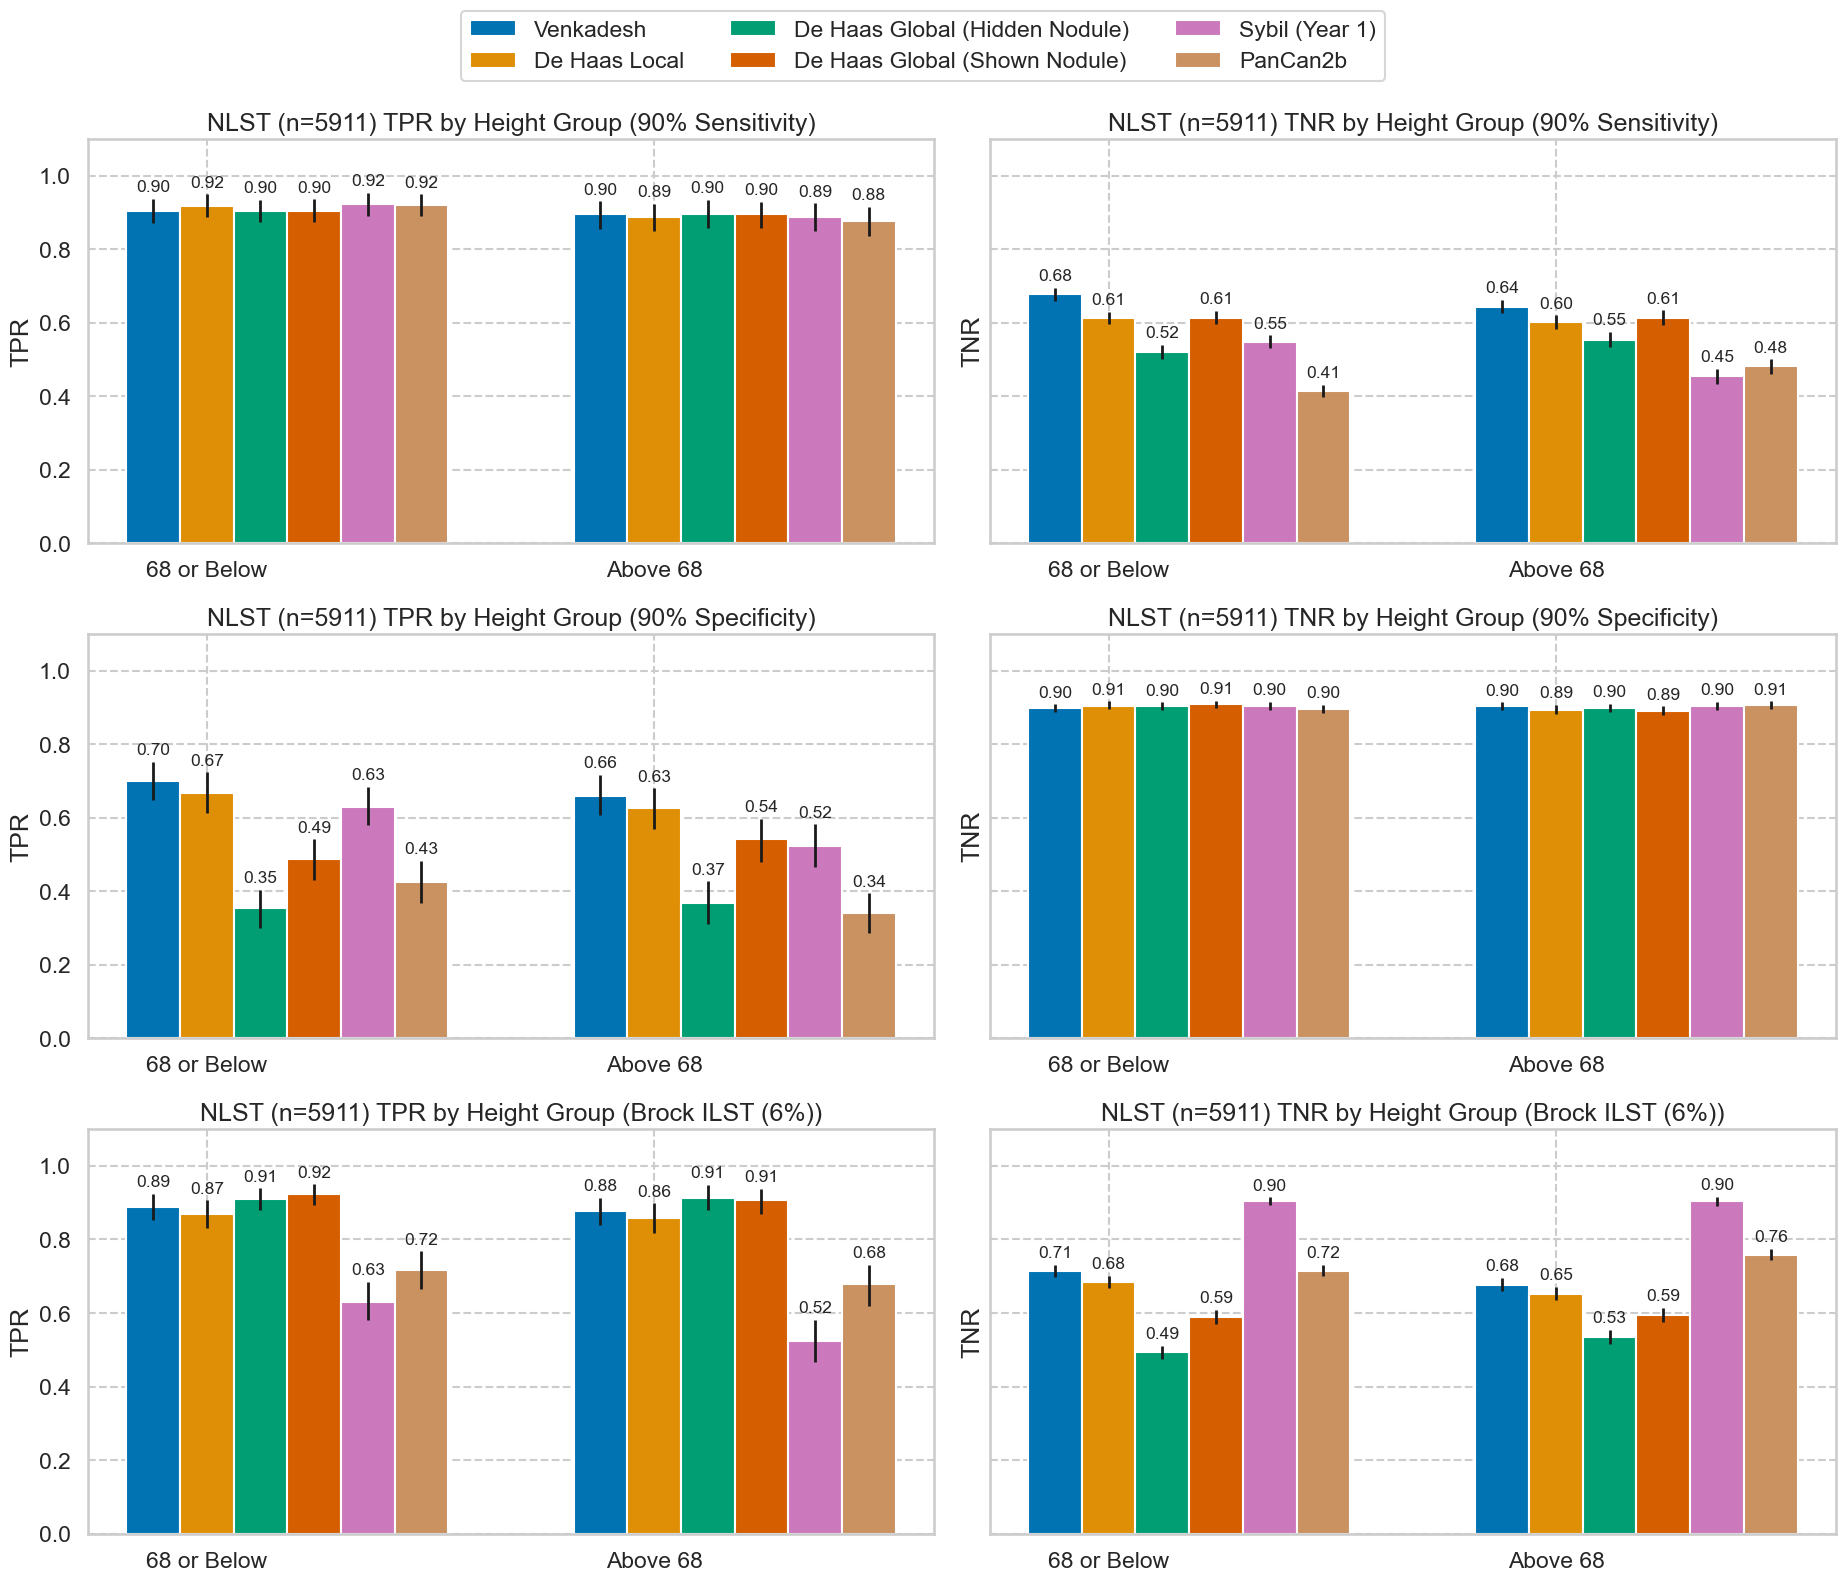

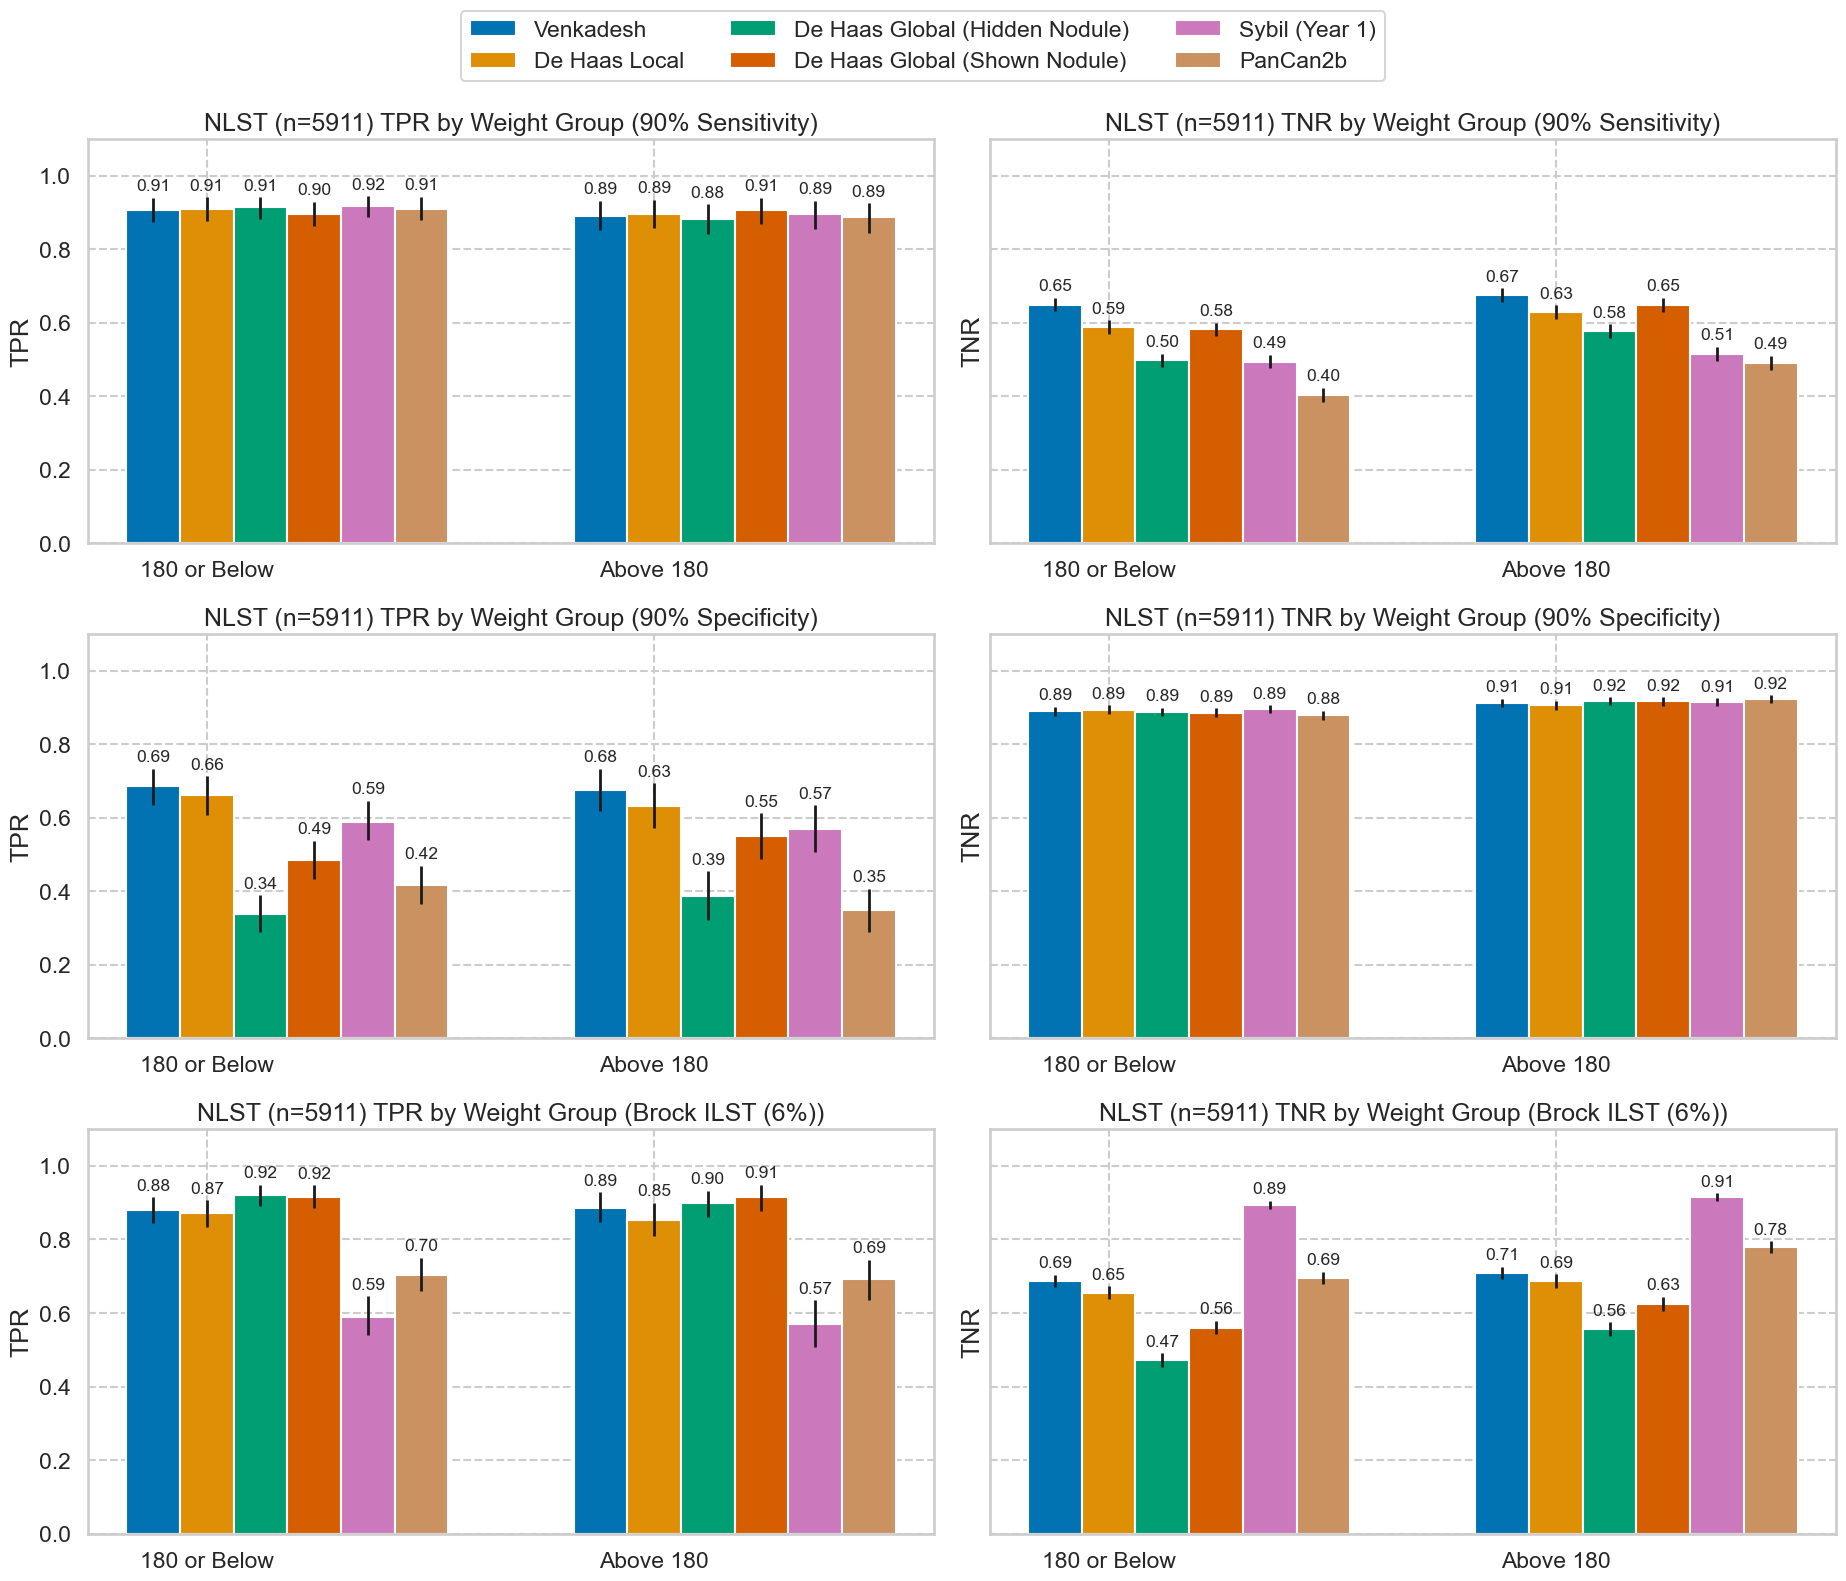

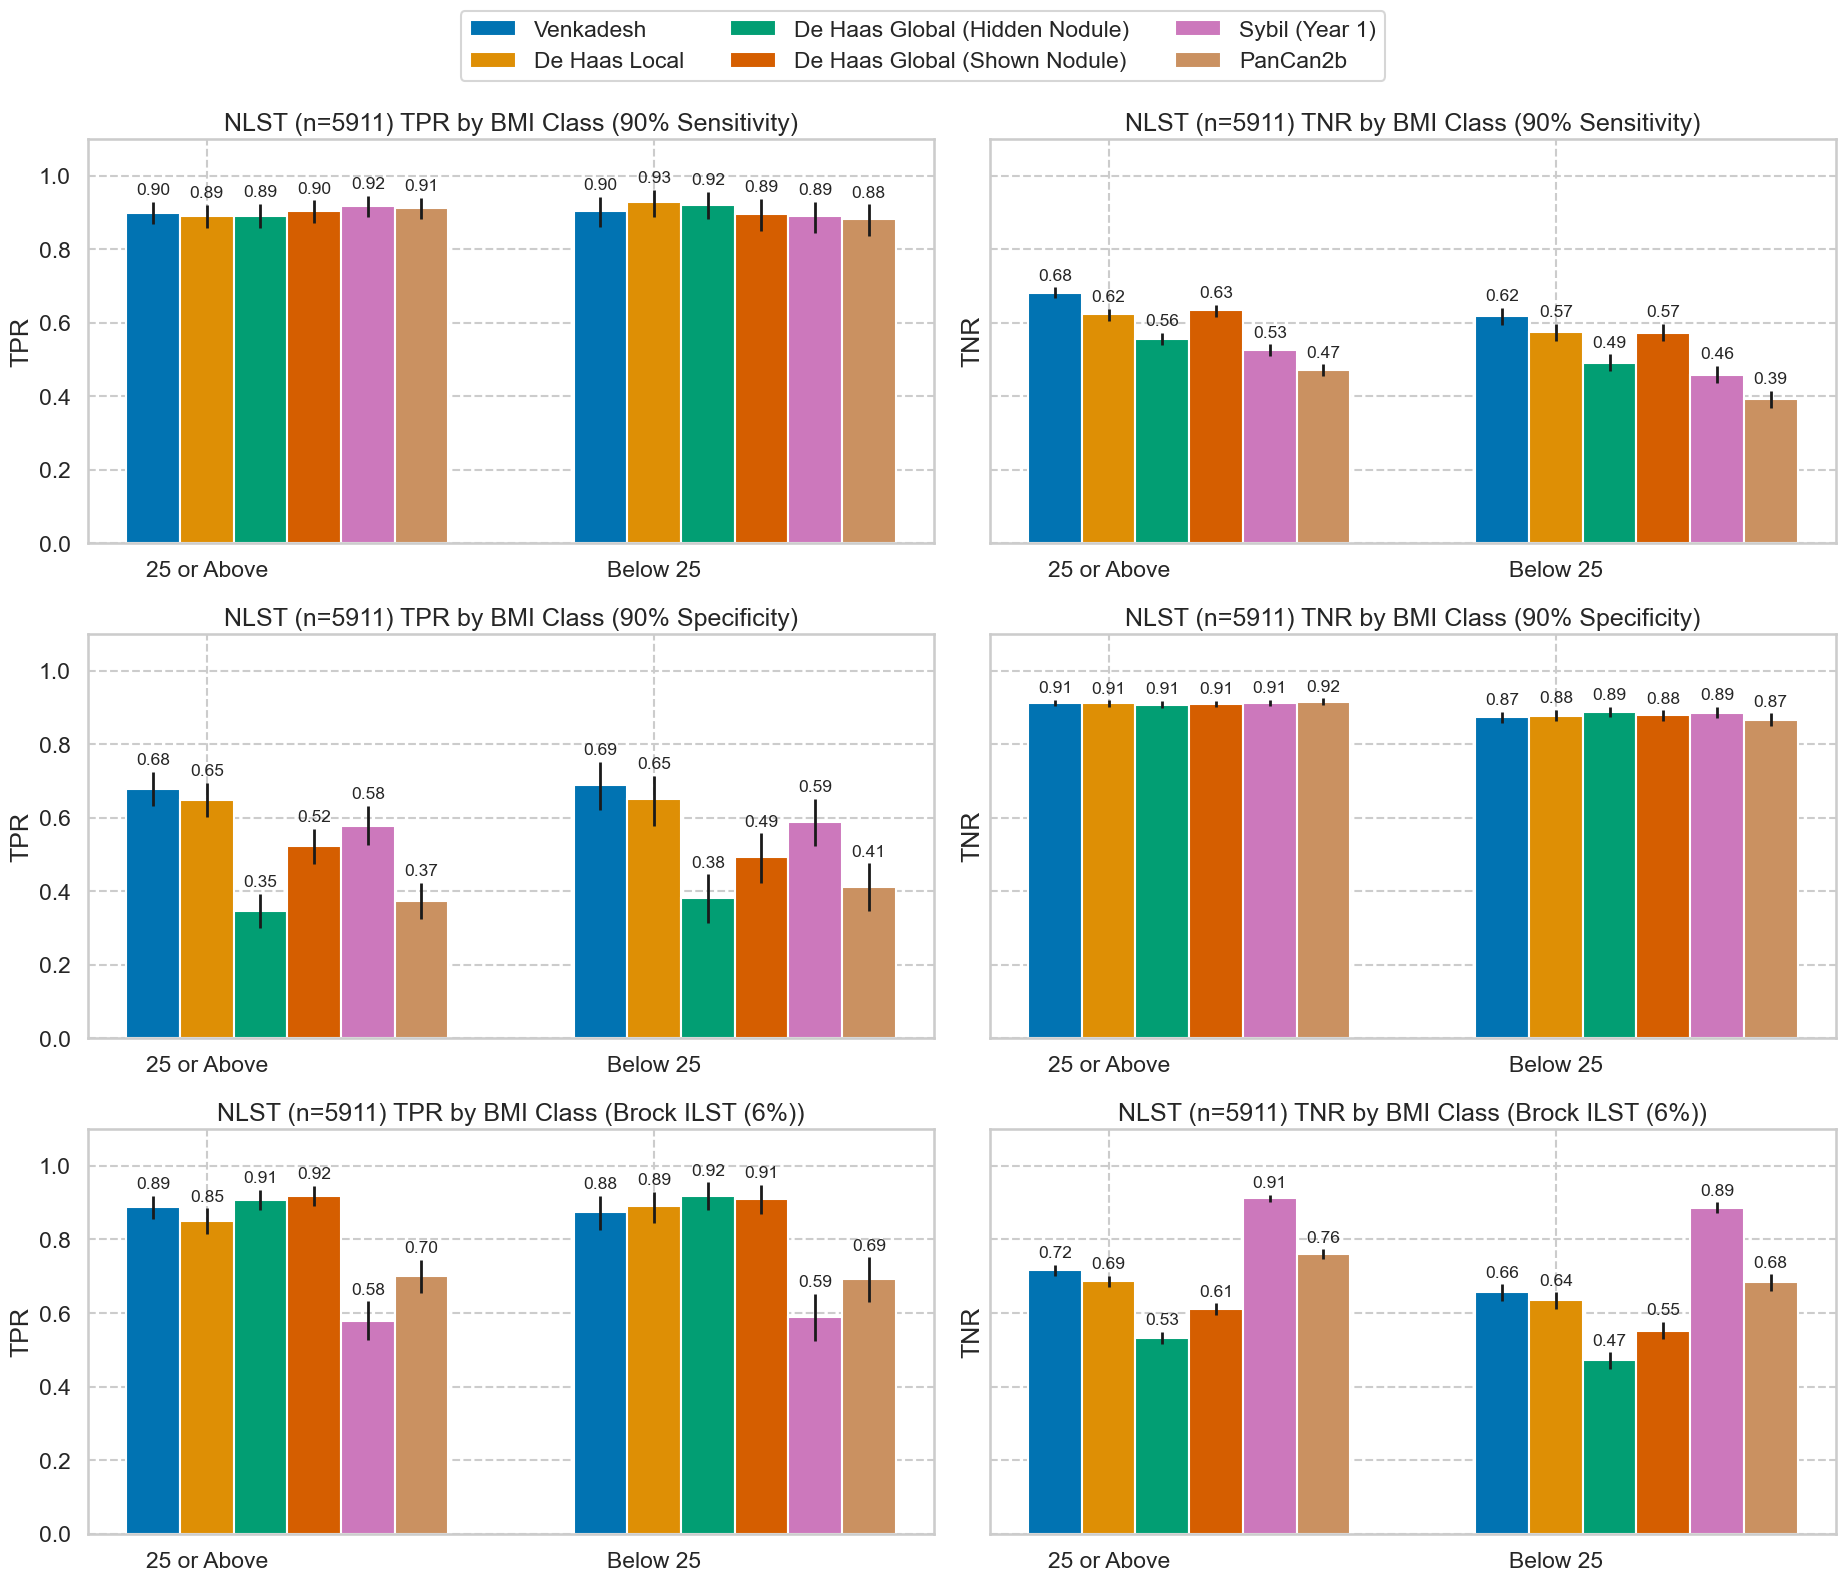

In [86]:
print(nlst_demos_to_include)
for col in nlst_demos_to_include:
    _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
                                                policies=nlst_5911_policies, models=NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
                                                plot_metrics=['TPR', 'TNR'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
                                                )  

## Demographic Confounder Links

In [20]:
from itertools import combinations

def num_with_percent(x, s, precision):
    return f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], precision)})'

def combine_center_spread(num_df):
    attributes = list(pd.unique(num_df['attribute']))
    for att in attributes:
        pass

def confounders_by_attribute(df, attribute, cols, precision=1):
    dfsets = {val: dfv for val, dfv in df.groupby(attribute)}
    subgroups = list(dfsets.keys())

    cat_df = data.combine_diff_dfs(cols['cat'], data.diffs_category_prevalence, dfsets)
    for s in dfsets:
        cat_df[f"{s}_info"] = cat_df.apply(lambda x: num_with_percent(x, s, precision), axis=1)
    
    cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))
    cat_df = cat_df[cat_df['attribute'] != attribute].query('value != False')
    cat_df = cat_df[[f"{s}_info" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in combinations(subgroups, 2)]]
    cat_df = cat_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)

    num_df = data.combine_diff_dfs(cols['num'], data.diffs_numerical_means, dfsets)
    num_df = num_df[num_df['attribute'] != attribute]
    num_df = num_df[num_df['value'].isin(['Median (IQR)'])]
    num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))
    num_df = num_df[[f"{s}" for s in subgroups] + [f"diff_{s1}_{s2}" for s1, s2 in combinations(subgroups, 2)]]
    num_df = num_df.sort_values(by=f"diff_{subgroups[0]}_{subgroups[1]}", ascending=True)

    display(cat_df)
    display(num_df)

    return cat_df, num_df

In [23]:
nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
cat_gender, num_gender = confounders_by_attribute(nlst_5911_v2, 'Gender', nlst_cols_v2)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:386: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


Female_info    Male_info  \
category          attribute         value                                
Smoking           Smoked Pipe       True         45 (1.8)  1256 (36.5)   
                  Smoked Cigars     True         83 (3.4)  1065 (31.0)   
Demographics      Married           True      1305 (52.8)  2669 (77.6)   
                  Marital Status    Married   1305 (52.8)  2669 (77.6)   
Other             Work Without Mask True       320 (13.0)  1184 (34.4)   
...                                                   ...          ...   
Disease Diagnosis Pneumonia         True       730 (29.6)   652 (18.9)   
Smoking           Lived with Smoker True      2334 (94.5)  2877 (83.6)   
Demographics      Marital Status    Widowed    380 (15.4)    127 (3.7)   
                                    Divorced   646 (26.2)   477 (13.9)   
                  BMI Class         Below 25   996 (40.3)   903 (26.2)   

                                              diff_Female_Male  
category          attribute         value                       
Smoking           Smoked Pipe       True              -34.6791  
                  Smoked Cigars     True              -27.5900  
Demographics      Married           True              -24.7307  
                  Marital Status    Married           -24.7307  
Other             Work Without Mask True              -21.4531  
...                                                        ...  
Disease Diagnosis Pneumonia         True               10.6067  
Smoking           Lived with Smoker True               10.8845  
Demographics      Marital Status    Widowed            11.6938  
                                    Divorced           12.2916  
                  BMI Class         Below 25           14.0815  

[185 rows x 3 columns]

Female      Male  \
category     attribute                 value                              
Demographics Weight                    Median (IQR)  157 (45)  192 (46)   
Smoking      Cigarettes per Day (avg.) Median (IQR)   20 (10)   30 (20)   
Other        Slices In Scan            Median (IQR)  155 (36)  165 (36)   
Smoking      Pack-Years                Median (IQR)   46 (22)   55 (35)   
Demographics Height                    Median (IQR)    64 (3)    71 (3)   
Smoking      Total Years of Smoking    Median (IQR)    40 (9)   42 (10)   
Demographics Age                       Median (IQR)    62 (8)    63 (8)   
             BMI                       Median (IQR)    26 (7)    27 (5)   
Other        Diameter (mm)             Median (IQR)     7 (4)     7 (5)   
             Nodules Per Scan          Median (IQR)     1 (1)     1 (1)   
Smoking      Age at Smoking Onset      Median (IQR)    17 (4)    16 (4)   

                                                     diff_Female_Male  
category     attribute                 value                           
Demographics Weight                    Median (IQR)           -35.000  
Smoking      Cigarettes per Day (avg.) Median (IQR)           -10.000  
Other        Slices In Scan            Median (IQR)           -10.000  
Smoking      Pack-Years                Median (IQR)            -9.000  
Demographics Height                    Median (IQR)            -7.000  
Smoking      Total Years of Smoking    Median (IQR)            -2.000  
Demographics Age                       Median (IQR)            -1.000  
             BMI                       Median (IQR)            -0.888  
Other        Diameter (mm)             Median (IQR)            -0.200  
             Nodules Per Scan          Median (IQR)             0.000  
Smoking      Age at Smoking Onset      Median (IQR)             1.000

In [22]:
# nlst_5911_v2, nlst_cols_v2, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, tijmen=False, sybil=True, pretty=True, bin_num=False)
cat_race, num_race = confounders_by_attribute(nlst_5911_v2, 'White or Black', nlst_cols_v2)

Black_info  \
category          attribute                  value                  
Demographics      Race                       White        0 (0.0)   
                  Non-Hispanic White         True         0 (0.0)   
                  Marital Status             Married    75 (39.9)   
                  Married                    True       75 (39.9)   
Smoking           Smoked Pipe                True        17 (9.0)   
...                                                           ...   
Demographics      Unfinished Education Level True       79 (42.0)   
Scanner           Manufacturer               SIEMENS   111 (59.0)   
Smoking           Current Smoker             True      129 (68.6)   
Disease Diagnosis Hypertension               True      102 (54.3)   
Demographics      Race                       Black    188 (100.0)   

                                                        White_info  \
category          attribute                  value                   
Demographics      Race                       White    5523 (100.0)   
                  Non-Hispanic White         True      5430 (98.3)   
                  Marital Status             Married   3759 (68.1)   
                  Married                    True      3759 (68.1)   
Smoking           Smoked Pipe                True      1259 (22.8)   
...                                                            ...   
Demographics      Unfinished Education Level True      1466 (26.5)   
Scanner           Manufacturer               SIEMENS   2220 (40.2)   
Smoking           Current Smoker             True      2734 (49.5)   
Disease Diagnosis Hypertension               True      1813 (32.8)   
Demographics      Race                       Black         0 (0.0)   

                                                      diff_Black_White  
category          attribute                  value                      
Demographics      Race                       White           -100.0000  
                  Non-Hispanic White         True             -98.3161  
                  Marital Status             Married          -28.1672  
                  Married                    True             -28.1672  
Smoking           Smoked Pipe                True             -13.7530  
...                                                                ...  
Demographics      Unfinished Education Level True              15.4778  
Scanner           Manufacturer               SIEMENS           18.8471  
Smoking           Current Smoker             True              19.1149  
Disease Diagnosis Hypertension               True              21.4289  
Demographics      Race                       Black            100.0000  

[164 rows x 3 columns]

Black     White  \
category     attribute                 value                              
Smoking      Pack-Years                Median (IQR)   43 (18)   51 (29)   
             Cigarettes per Day (avg.) Median (IQR)    20 (4)   25 (17)   
Demographics Height                    Median (IQR)    67 (7)    68 (6)   
             Weight                    Median (IQR)  180 (47)  180 (50)   
Other        Slices In Scan            Median (IQR)  161 (32)  161 (39)   
             Nodules Per Scan          Median (IQR)     1 (1)     1 (1)   
Demographics Age                       Median (IQR)    62 (7)    62 (8)   
Other        Diameter (mm)             Median (IQR)     7 (6)     7 (5)   
Demographics BMI                       Median (IQR)    27 (6)    26 (6)   
Smoking      Age at Smoking Onset      Median (IQR)    17 (4)    16 (4)   
             Total Years of Smoking    Median (IQR)    42 (9)   41 (10)   

                                                     diff_Black_White  
category     attribute                 value                           
Smoking      Pack-Years                Median (IQR)           -8.0000  
             Cigarettes per Day (avg.) Median (IQR)           -5.0000  
Demographics Height                    Median (IQR)           -1.0000  
             Weight                    Median (IQR)            0.0000  
Other        Slices In Scan            Median (IQR)            0.0000  
             Nodules Per Scan          Median (IQR)            0.0000  
Demographics Age                       Median (IQR)            0.5000  
Other        Diameter (mm)             Median (IQR)            0.6500  
Demographics BMI                       Median (IQR)            0.7401  
Smoking      Age at Smoking Onset      Median (IQR)            1.0000  
             Total Years of Smoking    Median (IQR)            1.0000